In [3]:
import numpy as np
import pandas as pd
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import folium # map rendering library
from IPython.display import HTML
import time
print ('Libraries Imported')

Libraries Imported


In [4]:
# plotting configurations

%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    
# table configuration
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "2px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "5px 8px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "5px 8px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "0")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

disp_fmt = "<h2 style='color: #b58900'>{}<span style='color: #FF91CE; font-size: 115%'>:</span></h2>"

### Loading and Preparing the Neighborhoods Data for New York City

#### Loading Neighborhood Data for New York City 

In [5]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [6]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [7]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [8]:
nyc_neighborhoods_data = newyork_data['features']
nyc_neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Transforming the JSON Data into a Pandas Dataframe

In [9]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
nyc_neighborhoods = pd.DataFrame(columns=column_names)

for data in nyc_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_neighborhoods = nyc_neighborhoods.append({'Borough': borough,
                                                  'Neighborhood': neighborhood_name,
                                                  'Latitude': neighborhood_lat,
                                                  'Longitude': neighborhood_lon}, ignore_index=True)

In [10]:
nyc_neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(nyc_neighborhoods['Borough'].unique()),
        nyc_neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


However, in this dataframe, there are neighborhoods that share the same name but are located in different boroughs as shown below:

In [12]:
nnvc = nyc_neighborhoods['Neighborhood'].value_counts()
nnvc[nnvc > 1]

Murray Hill    2
Sunnyside      2
Chelsea        2
Bay Terrace    2
Name: Neighborhood, dtype: int64

In [13]:
nyc_neighborhoods[nyc_neighborhoods['Neighborhood'] == 'Bay Terrace']

Borough Neighborhood   Latitude  Longitude
175         Queens  Bay Terrace  40.782843 -73.776802
235  Staten Island  Bay Terrace  40.553988 -74.139166

To deal with this case, we will include the borough name in the name of these neighborhoods. For example, "Bay Terrace" neighborhood which is located in "Staten Island" borough will be named "Bay Terrace, Staten Island" and the one in "Queens" will be named "Bay Terrace, Queens":

In [14]:
for i in range(nyc_neighborhoods.shape[0]):
    nyn_ = nyc_neighborhoods.loc[i, 'Neighborhood']
    if nyc_neighborhoods[nyc_neighborhoods['Neighborhood'] == nyn_].shape[0] > 1:
        ind_ = nyc_neighborhoods[nyc_neighborhoods['Neighborhood'] == nyn_].index.tolist()
        for j in ind_:
            nyb__ = nyc_neighborhoods.loc[j, 'Borough']
            nyc_neighborhoods.loc[j, 'Neighborhood'] = nyn_ + ', ' + nyb__

In [15]:
nyc_neighborhoods[nyc_neighborhoods['Neighborhood'].str.startswith('Bay Terrace')]

Borough                Neighborhood   Latitude  Longitude
175         Queens         Bay Terrace, Queens  40.782843 -73.776802
235  Staten Island  Bay Terrace, Staten Island  40.553988 -74.139166

#### Using `geopy` Library to get the Coordinates of New York City

In [16]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Creating a Map of New York City with neighborhoods Superimposed on Top.

In [17]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10, 
                         min_zoom=9, max_zoom=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(nyc_neighborhoods['Latitude'], 
                                           nyc_neighborhoods['Longitude'], 
                                           nyc_neighborhoods['Borough'], 
                                           nyc_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        weight=2,
        color='#333333',
        fill=True,
        fill_color='#ffb300',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Retrieving Venue Data For New York City

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    """
    A function that retrieves information about venues in each neighborhood.
    It takes as input a list of the names of the neighborhoods, a list of 
    their latitudes, and a list of their longitudes.
    It returns a dataframe with information about each neighborhood and its venues.
    """
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('•', end='')
            
        # create the API request URL
        url = ('https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}'
               '&v={}&ll={},{}&intent=browse&radius={}&limit={}'
               .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT))
            
        # make the GET request
        results = None
        while results is None:
            try:
                results = requests.get(url).json()["response"]["venues"]
            except:
                print('X', end='')
                results = None
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['name'], v['location']['lat'], 
                             v['location']['lng'], v['categories'][0]['name']) 
                            for v in results if len(v['categories']) > 0])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [20]:
nyc_venues = getNearbyVenues(names=nyc_neighborhoods['Neighborhood'],
                             latitudes=nyc_neighborhoods['Latitude'],
                             longitudes=nyc_neighborhoods['Longitude']
                            )

••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••

In [21]:
# Removing records where venue is "building" or "office"
nyc_venues = nyc_venues[~nyc_venues['Venue Category'].isin(['Building', 'Office', 'Bus Line', 'Bus Station', 'Bus Stop', 'Road'])]
print(nyc_venues.shape)
nyc_venues.head()

(23595, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   
5    Wakefield              40.894705              -73.847201   

                   Venue  Venue Latitude  Venue Longitude      Venue Category  
0  Julio C Barber Shop 2       40.892648       -73.855725  Salon / Barbershop  
1            Pitman Deli       40.896744       -73.844398                Food  
3       Lollipops Gelato       40.894123       -73.845892        Dessert Shop  
4       Public School 87       40.895487       -73.846004              School  
5                  Shell       40.891771       -73.853213         Gas Station

#### Let's check how many venues were returned for each neighborhood

In [22]:
nyc_venues.groupby('Neighborhood').size()

Neighborhood
Allerton                      83
Annadale                      77
Arden Heights                 65
Arlington                     70
Arrochar                      77
Arverne                       84
Astoria                       73
Astoria Heights               68
Auburndale                    62
Bath Beach                    81
Battery Park City             86
Bay Ridge                     83
Bay Terrace, Queens           82
Bay Terrace, Staten Island    75
Baychester                    81
Bayside                       84
Bayswater                     78
Bedford Park                  67
Bedford Stuyvesant            86
Beechhurst                    89
Bellaire                      75
Belle Harbor                  83
Bellerose                     81
Belmont                       62
Bensonhurst                   81
Bergen Beach                  78
Blissville                    77
Bloomfield                    73
Boerum Hill                   88
Borough Park                  

In [23]:
nyc_neighborhoods.shape[0], nyc_venues['Neighborhood'].unique().shape[0]

(306, 306)

We notice that there are 300 neighborhoods in the table while we had 306 neighborhoods before we got the data from Foursquare. This means that Foursquare didn't return any venue for a few neighborhoods.

In [24]:
nyc_excluded_neighborhoods = set(nyc_neighborhoods['Neighborhood']).difference(nyc_venues['Neighborhood'])
nyc_excluded_neighborhoods

set()

#### Let's find out how many unique categories can be curated from all the returned venues

In [25]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 579 uniques categories.


#### Performing one-hot on the venue category variable

In [26]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because
# there is a venue category called "Neighborhood"
nyc_onehot['Neighborhood_'] = nyc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

Neighborhood_  ATM  Accessories Store  Acupuncturist  Adult Boutique  \
0     Wakefield    0                  0              0               0   
1     Wakefield    0                  0              0               0   
3     Wakefield    0                  0              0               0   
4     Wakefield    0                  0              0               0   
5     Wakefield    0                  0              0               0   

   Advertising Agency  Afghan Restaurant  African Restaurant  Airport  \
0                   0                  0                   0        0   
1                   0                  0                   0        0   
3                   0                  0                   0        0   
4                   0                  0                   0        0   
5                   0                  0                   0        0   

   Airport Gate  Airport Service  Airport Terminal  Airport Tram  \
0             0                0                 0             0   
1             0                0                 0             0   
3             0                0                 0             0   
4             0                0                 0             0   
5             0                0                 0             0   

   Alternative Healer  American Restaurant  Animal Shelter  Antique Shop  \
0                   0                    0               0             0   
1                   0                    0               0             0   
3                   0                    0               0             0   
4                   0                    0               0             0   
5                   0                    0               0             0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                 0                       0            0           0   
1       0                 0                       0            0           0   
3       0                 0                       0            0           0   
4       0                 0                       0            0           0   
5       0                 0                       0            0           0   

   Art Studio  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0           0                    0                     0                 0   
1           0                    0                     0                 0   
3           0                    0                     0                 0   
4           0                    0                     0                 0   
5           0                    0                     0                 0   

   Assisted Living  Astrologer  Athletics & Sports  Auditorium  \
0                0           0                   0           0   
1                0           0                   0           0   
3                0           0                   0           0   
4                0           0                   0           0   
5                0           0                   0           0   

   Australian Restaurant  Auto Dealership  Auto Garage  Auto Workshop  \
0                      0                0            0              0   
1                      0                0            0              0   
3                      0                0            0              0   
4                      0                0            0              0   
5                      0                0            0              0   

   Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Baggage Claim  \
0                0          0           0           0              0   
1                0          0           0           0              0   
3                0          0           0           0              0   
4                0          0           0           0              0   
5                0          0           0           0              0   

   Baggage Locker  Bakery  Ballro

#### Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category for each neighborhood

In [27]:
nyc_grouped = nyc_onehot.groupby('Neighborhood_').mean().reset_index()
nyc_grouped.head()

Neighborhood_  ATM  Accessories Store  Acupuncturist  Adult Boutique  \
0       Allerton  0.0                0.0            0.0             0.0   
1       Annadale  0.0                0.0            0.0             0.0   
2  Arden Heights  0.0                0.0            0.0             0.0   
3      Arlington  0.0                0.0            0.0             0.0   
4       Arrochar  0.0                0.0            0.0             0.0   

   Advertising Agency  Afghan Restaurant  African Restaurant  Airport  \
0                 0.0                0.0                 0.0      0.0   
1                 0.0                0.0                 0.0      0.0   
2                 0.0                0.0                 0.0      0.0   
3                 0.0                0.0                 0.0      0.0   
4                 0.0                0.0                 0.0      0.0   

   Airport Gate  Airport Service  Airport Terminal  Airport Tram  \
0           0.0              0.0               0.0           0.0   
1           0.0              0.0               0.0           0.0   
2           0.0              0.0               0.0           0.0   
3           0.0              0.0               0.0           0.0   
4           0.0              0.0               0.0           0.0   

   Alternative Healer  American Restaurant  Animal Shelter  Antique Shop  \
0                 0.0             0.000000             0.0           0.0   
1                 0.0             0.038961             0.0           0.0   
2                 0.0             0.000000             0.0           0.0   
3                 0.0             0.014286             0.0           0.0   
4                 0.0             0.000000             0.0           0.0   

     Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0  0.000000               0.0                     0.0          0.0   
1  0.000000               0.0                     0.0          0.0   
2  0.000000               0.0                     0.0          0.0   
3  0.014286               0.0                     0.0          0.0   
4  0.000000               0.0                     0.0          0.0   

   Art Museum  Art Studio  Arts & Crafts Store  Arts & Entertainment  \
0         0.0         0.0             0.000000                   0.0   
1         0.0         0.0             0.000000                   0.0   
2         0.0         0.0             0.015385                   0.0   
3         0.0         0.0             0.000000                   0.0   
4         0.0         0.0             0.000000                   0.0   

   Asian Restaurant  Assisted Living  Astrologer  Athletics & Sports  \
0               0.0              0.0         0.0            0.000000   
1               0.0              0.0         0.0            0.000000   
2               0.0              0.0         0.0            0.000000   
3               0.0              0.0         0.0            0.000000   
4               0.0              0.0         0.0            0.012987   

   Auditorium  Australian Restaurant  Auto Dealership  Auto Garage  \
0         0.0                    0.0              0.0          0.0   
1         0.0                    0.0              0.0          0.0   
2         0.0                    0.0              0.0          0.0   
3         0.0                    0.0              0.0          0.0   
4         0.0                    0.0              0.0          0.0   

   Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  \
0            0.0         0.036145        0.0         0.0    0.000000   
1            0.0         0.012987        0.0         0.0    0.012987   
2            0.0         0.000000        0.0         0.0    0.015385   
3            0.0         0.057143        0.0         0.0    0.014286   
4            0.0         0.000000        0.0         0.0    0.025974   

   Baggage Claim  Baggage Locker    Bakery  Ballroom      Bank       Bar  \
0            0.0             0

#### The most common categories for each neighborhood

In [28]:
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]


num_top_cat = 7
indicators = ['st', 'nd', 'rd']

In [29]:
# create columns according to number of top venues
columns = ['Neighborhood_']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
nyc_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_neighborhoods_categories_sorted['Neighborhood_'] = nyc_grouped['Neighborhood_']

for ind in np.arange(nyc_grouped.shape[0]):
    nyc_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        nyc_grouped.iloc[ind, :], num_top_cat)

nyc_neighborhoods_categories_sorted.head()

Neighborhood_ 1st Most Common Category 2nd Most Common Category  \
0       Allerton       Salon / Barbershop          Laundry Service   
1       Annadale       Salon / Barbershop              Pizza Place   
2  Arden Heights                     Pool       Salon / Barbershop   
3      Arlington                   Church          Automotive Shop   
4       Arrochar            Deli / Bodega          Laundry Service   

                   3rd Most Common Category     4th Most Common Category  \
0                                  Pharmacy              Automotive Shop   
1                       American Restaurant                   Nail Salon   
2                             Moving Target  Professional & Other Places   
3  Residential Building (Apartment / Condo)           Salon / Barbershop   
4                           Doctor's Office                   Food Truck   

      5th Most Common Category 6th Most Common Category  \
0                     Car Wash               Non-Profit   
1                Tattoo Parlor                      Bar   
2                   Nail Salon                     Food   
3  Professional & Other Places           Hardware Store   
4                  Pizza Place       Italian Restaurant   

  7th Most Common Category  
0          Doctor's Office  
1                  Butcher  
2           Medical Center  
3               Playground  
4               Restaurant

### Clustering

Now we apply K-means clustering on the dataframe stored in toronto_grouped variable which includes the relative frequency of each venue-category for each neighborhood.


In [30]:
# set number of clusters
kclusters = 5

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 1, 3, 1, 1, 2, 1, 0, 1], dtype=int32)

In [31]:
# add clustering labels
nyc_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = nyc_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
nyc_merged = nyc_merged[~nyc_merged['Neighborhood_'].isin(nyc_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(nyc_neighborhoods_categories_sorted.set_index('Neighborhood_'), on='Neighborhood_')

nyc_merged.head() # check the last columns!

Borough Neighborhood_   Latitude  Longitude  Cluster Labels  \
0   Bronx     Wakefield  40.894705 -73.847201               3   
1   Bronx    Co-op City  40.874294 -73.829939               1   
2   Bronx   Eastchester  40.887556 -73.827806               0   
3   Bronx     Fieldston  40.895437 -73.905643               1   
4   Bronx     Riverdale  40.890834 -73.912585               2   

                   1st Most Common Category 2nd Most Common Category  \
0                        Salon / Barbershop                   Church   
1  Residential Building (Apartment / Condo)                   School   
2                           Automotive Shop            Deli / Bodega   
3                 College Academic Building   College Residence Hall   
4  Residential Building (Apartment / Condo)                Synagogue   

          3rd Most Common Category 4th Most Common Category  \
0                  Laundry Service          Coworking Space   
1                           Church                  Parking   
2             Caribbean Restaurant              Gas Station   
3  College Administrative Building             College Quad   
4                  Doctor's Office               Playground   

                   5th Most Common Category 6th Most Common Category  \
0                           Doctor's Office                     Food   
1                      Other Great Outdoors       Salon / Barbershop   
2                        Salon / Barbershop            Metro Station   
3  Residential Building (Apartment / Condo)           Cosmetics Shop   
4                                      Park         Dentist's Office   

  7th Most Common Category  
0               Playground  
1     Fast Food Restaurant  
2           Hardware Store  
3              College Gym  
4                  Dog Run

#### Creating a map that shows the neighborhoods and their clusters

We will create a map that shows a marker for each neighborhood; the color of the marker represents the cluster of the neighborhood.

In [32]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9,
                          min_zoom=8, max_zoom=11)

# set color scheme for the clusters
rainbow = pc[:5]

# add markers to the map
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], 
                                  nyc_merged['Neighborhood_'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        weight=1,
        popup=label,
        color='#333333',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

#### Examining clusters

Let's see the neighborhoods in each of the five clusters:

##### Cluster 1


In [33]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, 
               nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

Neighborhood_ 1st Most Common Category  \
2            Eastchester          Automotive Shop   
23              Longwood          Automotive Shop   
24           Hunts Point          Automotive Shop   
149        College Point          Automotive Shop   
152           Auburndale          Automotive Shop   
164        South Jamaica          Automotive Shop   
167  Springfield Gardens          Automotive Shop   
205        Port Richmond          Automotive Shop   
206     Mariner's Harbor          Automotive Shop   
269           Mount Eden          Automotive Shop   
278           Blissville              Gas Station   

                     2nd Most Common Category 3rd Most Common Category  \
2                               Deli / Bodega     Caribbean Restaurant   
23                                      Train              Pizza Place   
24                                    Factory       Mexican Restaurant   
149                        Salon / Barbershop       Mexican Restaurant   
152                                     Train               Nail Salon   
164                                    Church       Salon / Barbershop   
167                               Gas Station              High School   
205                             Deli / Bodega      Martial Arts School   
206                                    Church            Deli / Bodega   
269  Residential Building (Apartment / Condo)          Doctor's Office   
278                             Deli / Bodega           Hardware Store   

    4th Most Common Category 5th Most Common Category  \
2                Gas Station       Salon / Barbershop   
23                    Church       Salon / Barbershop   
24     General Entertainment              Gas Station   
149                     Bank            Deli / Bodega   
152            Deli / Bodega       Athletics & Sports   
164               Non-Profit          Laundry Service   
167              Pizza Place       Chinese Restaurant   
205              Pizza Place       Mexican Restaurant   
206       Salon / Barbershop                   School   
269              Pizza Place                      Bar   
278          Automotive Shop             Tech Startup   

        6th Most Common Category                  7th Most Common Category  
2                  Metro Station                            Hardware Store  
23                          Food                               Gas Station  
24                Farmers Market                                    School  
149              Doctor's Office                                    School  
152                       Lawyer  Residential Building (Apartment / Condo)  
164                  Pizza Place                        Chinese Restaurant  
167                Deli / Bodega                      Fast Food Restaurant  
205              Laundry Service                                    Church  
206  Professional & Other Places                        Miscellaneous Shop  
269               Cosmetics Shop                        Mexican Restaurant  
278                      Factory                           Laundry Service

### Loading and Preparing the Neighborhoods Data for Toronto

#### Extracting Neighborhoods Data from a Relevant Wikipedia Page

In [34]:
tor_neighborhoodss = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0)
tor_neighborhoods = tor_neighborhoodss[0]

In [35]:
tor_neighborhoods.head()

Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

In [36]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(tor_neighborhoods['Borough'].unique()),
        tor_neighborhoods.shape[0]
    )
)

The dataframe has 11 boroughs and 180 neighborhoods.


In [37]:
tor_neighborhoods.columns = ['PostalCode', 'Borough', 'Neighborhood']

In [38]:
tor_neighborhoods.head()

PostalCode           Borough               Neighborhood
0        M1A      Not assigned               Not assigned
1        M2A      Not assigned               Not assigned
2        M3A        North York                  Parkwoods
3        M4A        North York           Victoria Village
4        M5A  Downtown Toronto  Regent Park, Harbourfront

#### Removing records where the borough is "not assigned"

In [39]:
tor_neighborhoods[tor_neighborhoods.Borough == 'Not assigned']['Neighborhood'].unique()

array(['Not assigned'], dtype=object)

In [40]:
print("There are {} records where the borough is not assigned".format(
    tor_neighborhoods[tor_neighborhoods.Borough == 'Not assigned'].shape[0]))

There are 77 records where the borough is not assigned


In [41]:
tor_neighborhoods = tor_neighborhoods[tor_neighborhoods.Borough != 'Not assigned']

#### Merging records where multiple neighborhoods share the same borough

For example, there are two neighborhoods (Harbourfront and Regent Park) that share the same postal code and the same borough (Downtown Toronto) as shown below:

In [42]:
tor_neighborhoods[tor_neighborhoods.PostalCode == 'M5A']

PostalCode           Borough               Neighborhood
4        M5A  Downtown Toronto  Regent Park, Harbourfront

In [43]:
tor_neighborhoods = (tor_neighborhoods.groupby(['PostalCode', 'Borough'])['Neighborhood']
      .apply(lambda x: "{}".format(', '.join(x))).reset_index())

Now let's take a look at the record of Downtown Toronto borough:

In [44]:
tor_neighborhoods[tor_neighborhoods.PostalCode == 'M5A']

PostalCode           Borough               Neighborhood
53        M5A  Downtown Toronto  Regent Park, Harbourfront

#### Dealing with the case where the neighborhood is "not assigned"

For some records in the table, there is a valid value for the borough but the neighborhood has the value "Not assigned" as shown below:

In [45]:
tor_neighborhoods[tor_neighborhoods.Neighborhood.str.contains('Not assigned')]

Empty DataFrame
Columns: [PostalCode, Borough, Neighborhood]
Index: []

In [46]:
tor_neighborhoods.loc[tor_neighborhoods.Neighborhood.str.contains('Not assigned'), 'Neighborhood'] = \
    tor_neighborhoods.loc[tor_neighborhoods.Neighborhood.str.contains('Not assigned'), 'Borough']

Now let's take a look at the previous record:

In [47]:
tor_neighborhoods[tor_neighborhoods.Borough == "Queen's Park"]

Empty DataFrame
Columns: [PostalCode, Borough, Neighborhood]
Index: []

#### Getting Latitude and Longitude Coordinates of the Neighborhoods

In [48]:
tor_lat_lng_df = pd.read_csv('http://cocl.us/Geospatial_data')

In [49]:
tor_lat_lng_df.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

#### Adding langitude and latitude to the neighborhoods dataframe

In [50]:
tor_neighborhoods.reset_index(drop=True, inplace=True)
tor_neighborhoods['Latitude'] = -99999.9
tor_neighborhoods['Longitude'] = -99999.9

for i in range(tor_neighborhoods.shape[0]):
    postalcode = tor_neighborhoods.loc[i, 'PostalCode']
    lat = tor_lat_lng_df.loc[tor_lat_lng_df['Postal Code'] == postalcode, 'Latitude'].squeeze()
    lng = tor_lat_lng_df.loc[tor_lat_lng_df['Postal Code'] == postalcode, 'Longitude'].squeeze()
    tor_neighborhoods.loc[i, 'Latitude'] = lat
    tor_neighborhoods.loc[i, 'Longitude'] = lng    

In [51]:
tor_neighborhoods.head()

PostalCode      Borough                            Neighborhood   Latitude  \
0        M1B  Scarborough                          Malvern, Rouge  43.806686   
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [52]:
tor_neighborhoods.shape

(103, 5)

#### Using geopy Library to get the Coordinates of Toronto

In [53]:
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Creating a map of Toronto with neighborhoods superimposed on top

In [54]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10,
                         min_zoom=9, max_zoom=11)

# add neighborhood markers to map
for lat, lng, borough, neighborhood in zip(tor_neighborhoods['Latitude'], tor_neighborhoods['Longitude'], 
                                           tor_neighborhoods['Borough'], tor_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        weight=2,
        popup=label,
        color='#333333',
        fill=True,
        fill_color='#388e3c',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Retrieving Venue Data For Toronto

In [55]:
tor_venues = getNearbyVenues(names=tor_neighborhoods['Neighborhood'],
                             latitudes=tor_neighborhoods['Latitude'],
                             longitudes=tor_neighborhoods['Longitude']
                            )

•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••

In [56]:
# Removing records where venue is "building" or "office"
tor_venues = tor_venues[~tor_venues['Venue Category'].isin(['Building', 'Office', 'Bus Line', 'Bus Station', 'Bus Stop', 'Road'])]
print(tor_venues.shape)
tor_venues.head()

(7798, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Malvern, Rouge              43.806686              -79.194353   
1  Malvern, Rouge              43.806686              -79.194353   
2  Malvern, Rouge              43.806686              -79.194353   
4  Malvern, Rouge              43.806686              -79.194353   
5  Malvern, Rouge              43.806686              -79.194353   

                         Venue  Venue Latitude  Venue Longitude  \
0  Rouge Park - Woodland Trail       43.801782       -79.200427   
1                        Shell       43.803227       -79.192414   
2  Alvin Curling Public School       43.808683       -79.190103   
4                    Frito Lay       43.803844       -79.194841   
5              Pleasant Corner       43.801164       -79.200254   

      Venue Category  
0              Trail  
1        Gas Station  
2  Elementary School  
4            Factory  
5      Shopping Mall

#### Let's check how many venues were returned for each neighborhood

In [57]:
tor_venues.groupby('Neighborhood').size()

Neighborhood
Agincourt                                                                                                                                  79
Alderwood, Long Branch                                                                                                                     81
Bathurst Manor, Wilson Heights, Downsview North                                                                                            82
Bayview Village                                                                                                                            82
Bedford Park, Lawrence Manor East                                                                                                          85
Berczy Park                                                                                                                                61
Birch Cliff, Cliffside West                                                                                                            

In [58]:
tor_neighborhoods.shape[0], tor_venues['Neighborhood'].unique().shape[0]

(103, 99)

We notice that there are 301 neighborhoods in the table while we had 306 neighborhoods before we got the data from Foursquare. This means that Foursquare didn't return any venue for 5 neighborhoods. These 5 neighborhoods are:

In [59]:
tor_excluded_neighborhoods = set(tor_neighborhoods['Neighborhood']).difference(set(tor_venues['Neighborhood']))
tor_excluded_neighborhoods

set()

#### Let's find out how many unique categories can be curated from all the returned venues

In [60]:
print('There are {} uniques categories.'.format(len(tor_venues['Venue Category'].unique())))

There are 505 uniques categories.


#### Performing one-hot on the venue category variable

In [61]:
# one hot encoding
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because
# there is a venue category called "Neighborhood"
tor_onehot['Neighborhood_'] = tor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_onehot.head()

Neighborhood_  ATM  Accessories Store  Acupuncturist  Adult Boutique  \
0  Malvern, Rouge    0                  0              0               0   
1  Malvern, Rouge    0                  0              0               0   
2  Malvern, Rouge    0                  0              0               0   
4  Malvern, Rouge    0                  0              0               0   
5  Malvern, Rouge    0                  0              0               0   

   Advertising Agency  Afghan Restaurant  African Restaurant  Airport  \
0                   0                  0                   0        0   
1                   0                  0                   0        0   
2                   0                  0                   0        0   
4                   0                  0                   0        0   
5                   0                  0                   0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
4                   0             0               0                0   
5                   0             0               0                0   

   Airport Terminal  Alternative Healer  American Restaurant  Animal Shelter  \
0                 0                   0                    0               0   
1                 0                   0                    0               0   
2                 0                   0                    0               0   
4                 0                   0                    0               0   
5                 0                   0                    0               0   

   Antique Shop  Aquarium  Arcade  Argentinian Restaurant  Art Gallery  \
0             0         0       0                       0            0   
1             0         0       0                       0            0   
2             0         0       0                       0            0   
4             0         0       0                       0            0   
5             0         0       0                       0            0   

   Art Studio  Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0           0                    0                     0                 0   
1           0                    0                     0                 0   
2           0                    0                     0                 0   
4           0                    0                     0                 0   
5           0                    0                     0                 0   

   Assisted Living  Athletics & Sports  Auditorium  Auto Dealership  \
0                0                   0           0                0   
1                0                   0           0                0   
2                0                   0           0                0   
4                0                   0           0                0   
5                0                   0           0                0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  \
0            0              0                0          0           0   
1            0              0                0          0           0   
2            0              0                0          0           0   
4            0              0                0          0           0   
5            0              0                0          0           0   

   Bagel Shop  Baggage Claim  Bakery  Ballroom  Bank  Bar  Baseball Field  \
0           0              0       0         0     0    0               0   
1           0              0       0         0     0    0               0   
2           0              0       0         0     0    0               0   
4           0              0       0         0     0    0               0   
5           0              0 

#### Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category for each neighborhood

In [62]:
tor_grouped = tor_onehot.groupby('Neighborhood_').mean().reset_index()
tor_grouped.head()

Neighborhood_  ATM  Accessories Store  \
0                                        Agincourt  0.0                0.0   
1                           Alderwood, Long Branch  0.0                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North  0.0                0.0   
3                                  Bayview Village  0.0                0.0   
4                Bedford Park, Lawrence Manor East  0.0                0.0   

   Acupuncturist  Adult Boutique  Advertising Agency  Afghan Restaurant  \
0       0.000000             0.0                 0.0                0.0   
1       0.000000             0.0                 0.0                0.0   
2       0.000000             0.0                 0.0                0.0   
3       0.012195             0.0                 0.0                0.0   
4       0.000000             0.0                 0.0                0.0   

   African Restaurant  Airport  Airport Food Court  Airport Gate  \
0                 0.0      0.0                 0.0           0.0   
1                 0.0      0.0                 0.0           0.0   
2                 0.0      0.0                 0.0           0.0   
3                 0.0      0.0                 0.0           0.0   
4                 0.0      0.0                 0.0           0.0   

   Airport Lounge  Airport Service  Airport Terminal  Alternative Healer  \
0             0.0              0.0               0.0                 0.0   
1             0.0              0.0               0.0                 0.0   
2             0.0              0.0               0.0                 0.0   
3             0.0              0.0               0.0                 0.0   
4             0.0              0.0               0.0                 0.0   

   American Restaurant  Animal Shelter  Antique Shop  Aquarium    Arcade  \
0             0.000000             0.0      0.000000       0.0  0.012658   
1             0.000000             0.0      0.000000       0.0  0.000000   
2             0.000000             0.0      0.000000       0.0  0.000000   
3             0.000000             0.0      0.000000       0.0  0.000000   
4             0.011765             0.0      0.011765       0.0  0.000000   

   Argentinian Restaurant  Art Gallery  Art Studio  Arts & Crafts Store  \
0                     0.0          0.0         0.0             0.000000   
1                     0.0          0.0         0.0             0.012346   
2                     0.0          0.0         0.0             0.000000   
3                     0.0          0.0         0.0             0.000000   
4                     0.0          0.0         0.0             0.000000   

   Arts & Entertainment  Asian Restaurant  Assisted Living  \
0                   0.0          0.000000         0.000000   
1                   0.0          0.024691         0.000000   
2                   0.0          0.000000         0.000000   
3                   0.0          0.024390         0.012195   
4                   0.0          0.000000         0.000000   

   Athletics & Sports  Auditorium  Auto Dealership  Auto Garage  \
0            0.012658    0.000000         0.000000     0.025316   
1            0.000000    0.000000         0.012346     0.000000   
2            0.000000    0.012195         0.000000     0.000000   
3            0.000000    0.000000         0.000000     0.000000   
4            0.000000    0.000000         0.000000     0.000000   

   Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  \
0            0.0         0.151899   0.012658         0.0         0.0   
1            0.0         0.000000   0.024691         0.0         0.0   
2            0.0         0.000000   0.000000         0.0         0.0   
3            0.0         0.012195   0.000000         0.0         0.0   
4            0.0         0.000000   0.000000         0.0         0.0   

   Baggage Claim    Bakery  Ballroom      Bank       Bar  Baseball Field  \
0            0.0  0.000000       0.0  0.000000  0.000000  

#### The most common categories for each neighborhood

In [63]:
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]


num_top_cat = 7
indicators = ['st', 'nd', 'rd']

In [64]:
# create columns according to number of top venues
columns = ['Neighborhood_']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
tor_neighborhoods_categories_sorted['Neighborhood_'] = tor_grouped['Neighborhood_']

for ind in np.arange(tor_grouped.shape[0]):
    tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        tor_grouped.iloc[ind, :], num_top_cat)

tor_neighborhoods_categories_sorted.head()

Neighborhood_  \
0                                        Agincourt   
1                           Alderwood, Long Branch   
2  Bathurst Manor, Wilson Heights, Downsview North   
3                                  Bayview Village   
4                Bedford Park, Lawrence Manor East   

                   1st Most Common Category  \
0                           Automotive Shop   
1                                   Daycare   
2                           Doctor's Office   
3  Residential Building (Apartment / Condo)   
4                        Salon / Barbershop   

                   2nd Most Common Category 3rd Most Common Category  \
0                                    Church          Doctor's Office   
1                           Conference Room       Salon / Barbershop   
2  Residential Building (Apartment / Condo)           Medical Center   
3                           Doctor's Office                   Church   
4                        Italian Restaurant         Sushi Restaurant   

  4th Most Common Category 5th Most Common Category 6th Most Common Category  \
0         Storage Facility      Rental Car Location              Post Office   
1              Gas Station           Medical Center                     Bank   
2                Synagogue                     Bank           Ice Cream Shop   
3                     Park                  Dog Run                   School   
4                      Spa               Restaurant           Sandwich Place   

  7th Most Common Category  
0              Event Space  
1         Dentist's Office  
2        Convenience Store  
3           Medical Center  
4              Gas Station

### Clustering

Now we apply K-means clustering on the dataframe stored in toronto_grouped variable which includes the relative frequency of each venue-category for each neighborhood.


In [65]:
# set number of clusters
kclusters = 5

tor_grouped_clustering = tor_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 1, 1, 0, 1, 1, 2, 1, 4], dtype=int32)

In [66]:
# add clustering labels
tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tor_merged = tor_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
tor_merged = tor_merged[~tor_merged['Neighborhood_'].isin(tor_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tor_merged = tor_merged.join(tor_neighborhoods_categories_sorted.set_index('Neighborhood_'), on='Neighborhood_')

tor_merged.head() # check the last columns!

PostalCode      Borough                           Neighborhood_   Latitude  \
0        M1B  Scarborough                          Malvern, Rouge  43.806686   
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  Cluster Labels                  1st Most Common Category  \
0 -79.194353               3                           Automotive Shop   
1 -79.160497               3                           Automotive Shop   
2 -79.188711               1  Residential Building (Apartment / Condo)   
3 -79.216917               1                            Cosmetics Shop   
4 -79.239476               1                            Medical Center   

  2nd Most Common Category                  3rd Most Common Category  \
0                  Factory                        Salon / Barbershop   
1           Medical Center                        Salon / Barbershop   
2        Electronics Store                                Restaurant   
3        Convenience Store  Residential Building (Apartment / Condo)   
4                   Bakery                           Doctor's Office   

  4th Most Common Category                  5th Most Common Category  \
0         Dentist's Office                               Coffee Shop   
1    General Entertainment                                      Park   
2                   Church                              Tech Startup   
3              Coffee Shop                        Salon / Barbershop   
4          Automotive Shop  Residential Building (Apartment / Condo)   

  6th Most Common Category 7th Most Common Category  
0           Medical Center              Gas Station  
1                   Church          Laundry Service  
2   Thrift / Vintage Store                     Bank  
3                 Pharmacy        Indian Restaurant  
4             Burger Joint             Skating Rink

#### Creating a map that shows the neighborhoods and their clusters

We will create a map that shows a marker for each neighborhood; the color of the marker represents the cluster of the neighborhood.

In [67]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9,
                          min_zoom=8, max_zoom=10)

# set color scheme for the clusters
rainbow = pc[:5]

# add markers to the map
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], 
                                  tor_merged['Neighborhood_'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        weight=1,
        popup=label,
        color='#333333',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

#### Examining clusters

Let's see the neighborhoods in each of the five clusters:

##### Cluster 1


In [68]:
tor_merged.loc[tor_merged['Cluster Labels'] == 0, 
               tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

Borough  Cluster Labels    1st Most Common Category  \
11        Scarborough               0   Middle Eastern Restaurant   
16        Scarborough               0                 Zoo Exhibit   
18         North York               0              Clothing Store   
29         North York               0              Medical Center   
38          East York               0                        Bank   
41       East Toronto               0            Greek Restaurant   
43       East Toronto               0                 Coffee Shop   
46    Central Toronto               0                  Shoe Store   
47    Central Toronto               0                 Coffee Shop   
54   Downtown Toronto               0                 College Lab   
57   Downtown Toronto               0                    Hospital   
58   Downtown Toronto               0                 Coffee Shop   
60   Downtown Toronto               0                 Coffee Shop   
61   Downtown Toronto               0  Financial or Legal Service   
62         North York               0          Salon / Barbershop   
67   Downtown Toronto               0      Thrift / Vintage Store   
70   Downtown Toronto               0                 Coffee Shop   
71         North York               0              Clothing Store   
77       West Toronto               0                         Bar   
84       West Toronto               0            Dentist's Office   
86        Mississauga               0                       Hotel   
90          Etobicoke               0          Miscellaneous Shop   
101         Etobicoke               0          Salon / Barbershop   

            2nd Most Common Category       3rd Most Common Category  \
11                     Grocery Store                 Medical Center   
16                    Cosmetics Shop                           Park   
18                        Shoe Store                  Women's Store   
29            Furniture / Home Store                Doctor's Office   
38               Sporting Goods Shop         Furniture / Home Store   
41                               Spa           Gym / Fitness Center   
43                   Automotive Shop                     Restaurant   
46           Health & Beauty Service                 Cosmetics Shop   
47                Italian Restaurant                           Café   
54   College Administrative Building      College Academic Building   
57                     Hospital Ward                 Medical Center   
58                        Food Court  Vegetarian / Vegan Restaurant   
60                              Café                     Restaurant   
61                       Coffee Shop                     Food Court   
62                Italian Restaurant               Sushi Restaurant   
67                Salon / Barbershop                       Boutique   
70                  Dentist's Office                         Bakery   
71            Furniture / Home Store                  Design Studio   
77                       Coffee Shop                    Art Gallery   
84                    Medical Center             Salon / Barbershop   
86                 Convenience Store             Chinese Restaurant   
90                               Spa               Dentist's Office   
101                    Movie Theater               Spiritual Center   

         4th Most Common Category 5th Most Common Category  \
11                   Intersection              Coffee Shop   
16                          Trail               Playground   
18                 Cosmetics Shop          Doctor's Office   
29                   Optical Shop         Fraternity House   
38                    Coffee Shop           Sandwich Place   
41             Salon / Barbershop       Miscellaneous Shop   
43                     Nail Salon            Moving Target   
46                 Clothing Store   Furniture / Home Store   
47                            Spa       Salon / Barbershop   
54   General College & Universit

In [69]:
#print(nyc_top_vc.head(15))
#tor_top_vc.head(15)

### EDA

#### Most Common Venue Categories in NYC

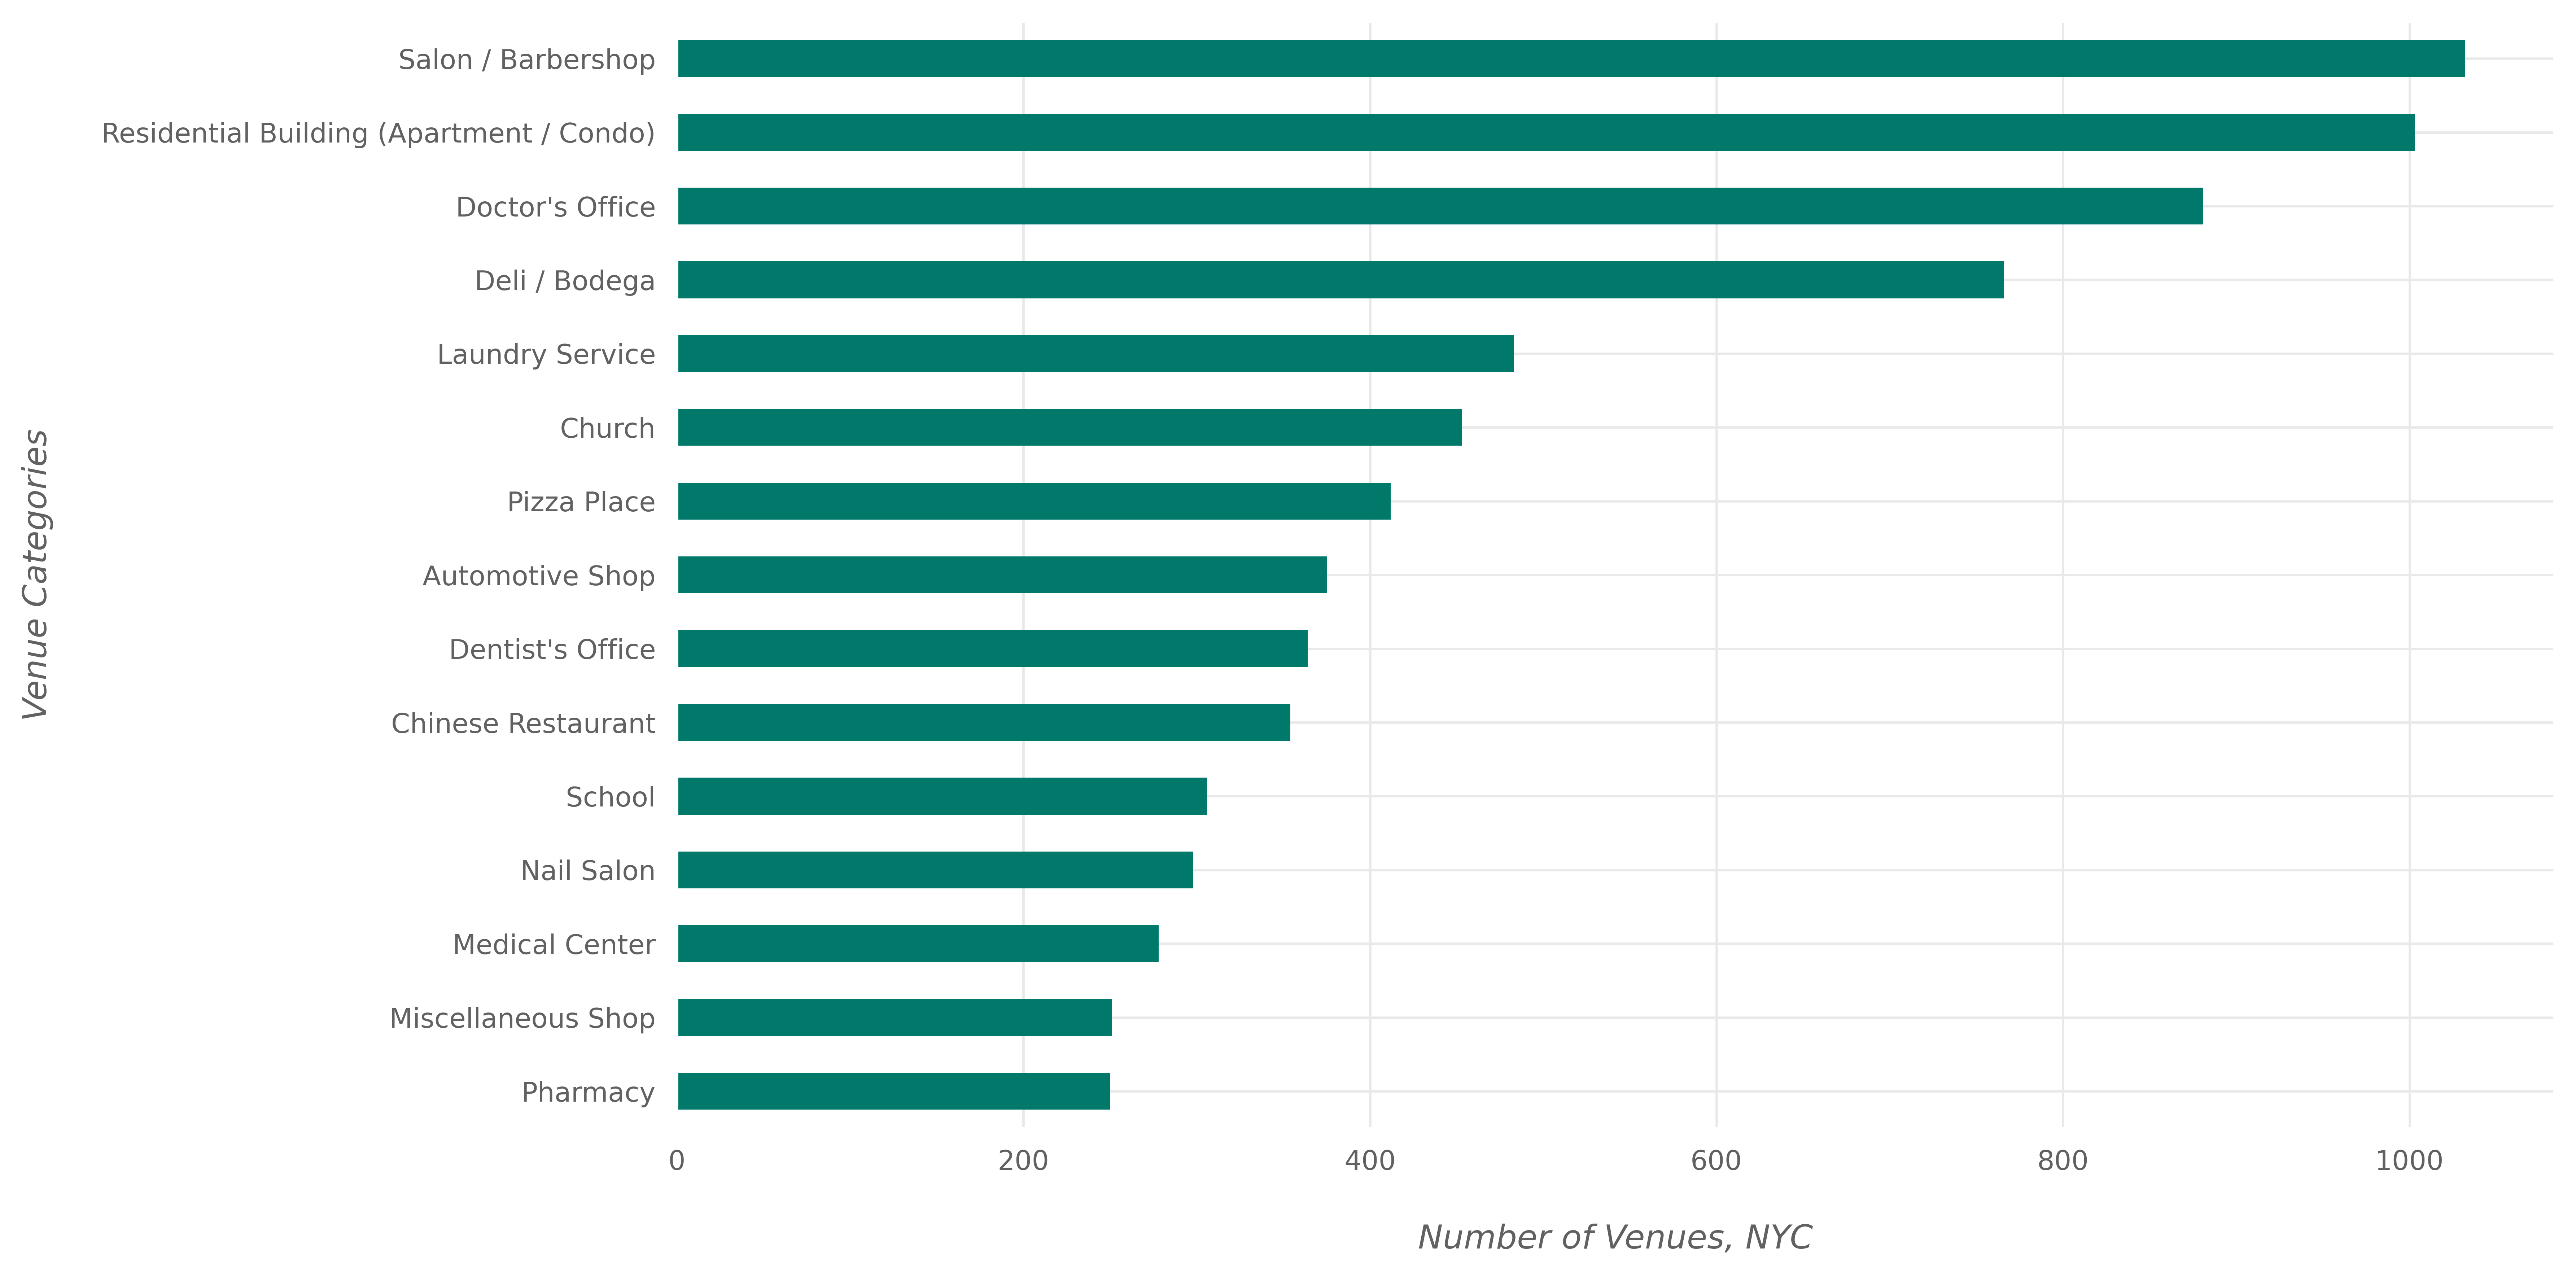

In [70]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_top_vc = nyc_venues['Venue Category'].value_counts(normalize=False)
ax = nyc_top_vc.head(15).plot(kind='barh', color=pc[10]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of Venues, NYC', ylbl='Venue Categories', t='')
plt.tight_layout()
fig.savefig('most-common-ven-nyc.png', dpi=300)

#### Most Common Venue Categories in Toronto

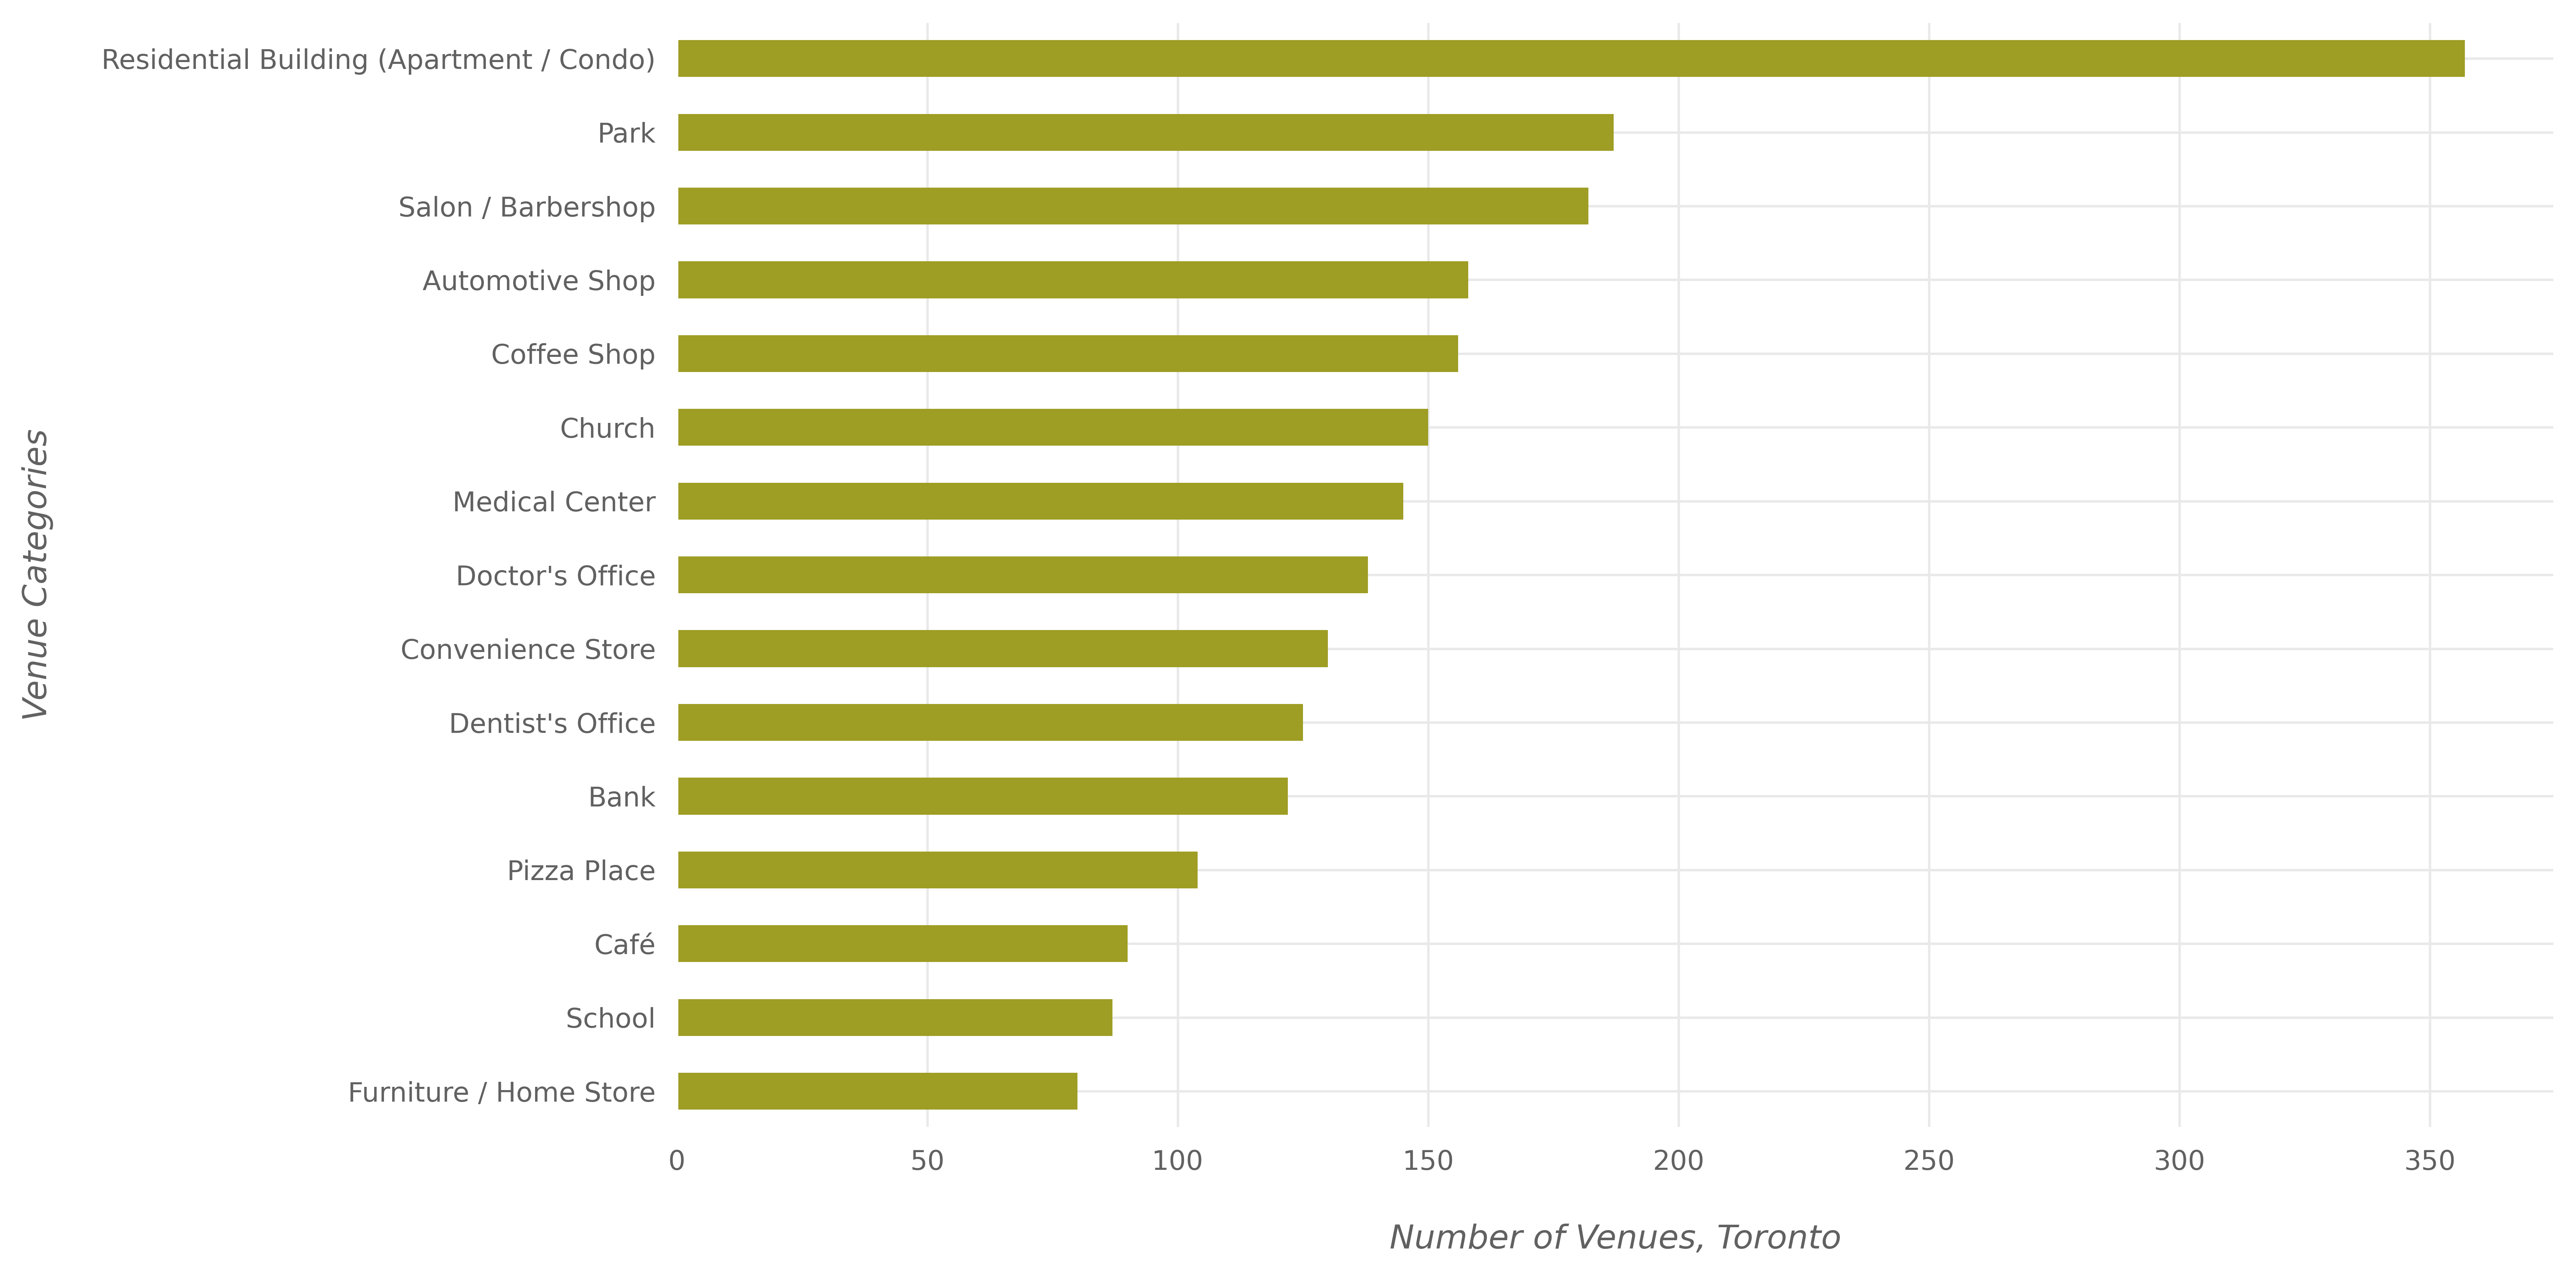

In [71]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_top_vc = tor_venues['Venue Category'].value_counts(normalize=False)
ax = tor_top_vc.head(15).plot(kind='barh', color=pc[7]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of Venues, Toronto', ylbl='Venue Categories', t='')
plt.tight_layout()
fig.savefig('most-common-ven-tor.png', dpi=300)

#### Which Venue Categories Exist in More NYC Neighborhoods?

In [72]:
#tor_p.head(15)

306 neighborhoods in NYC


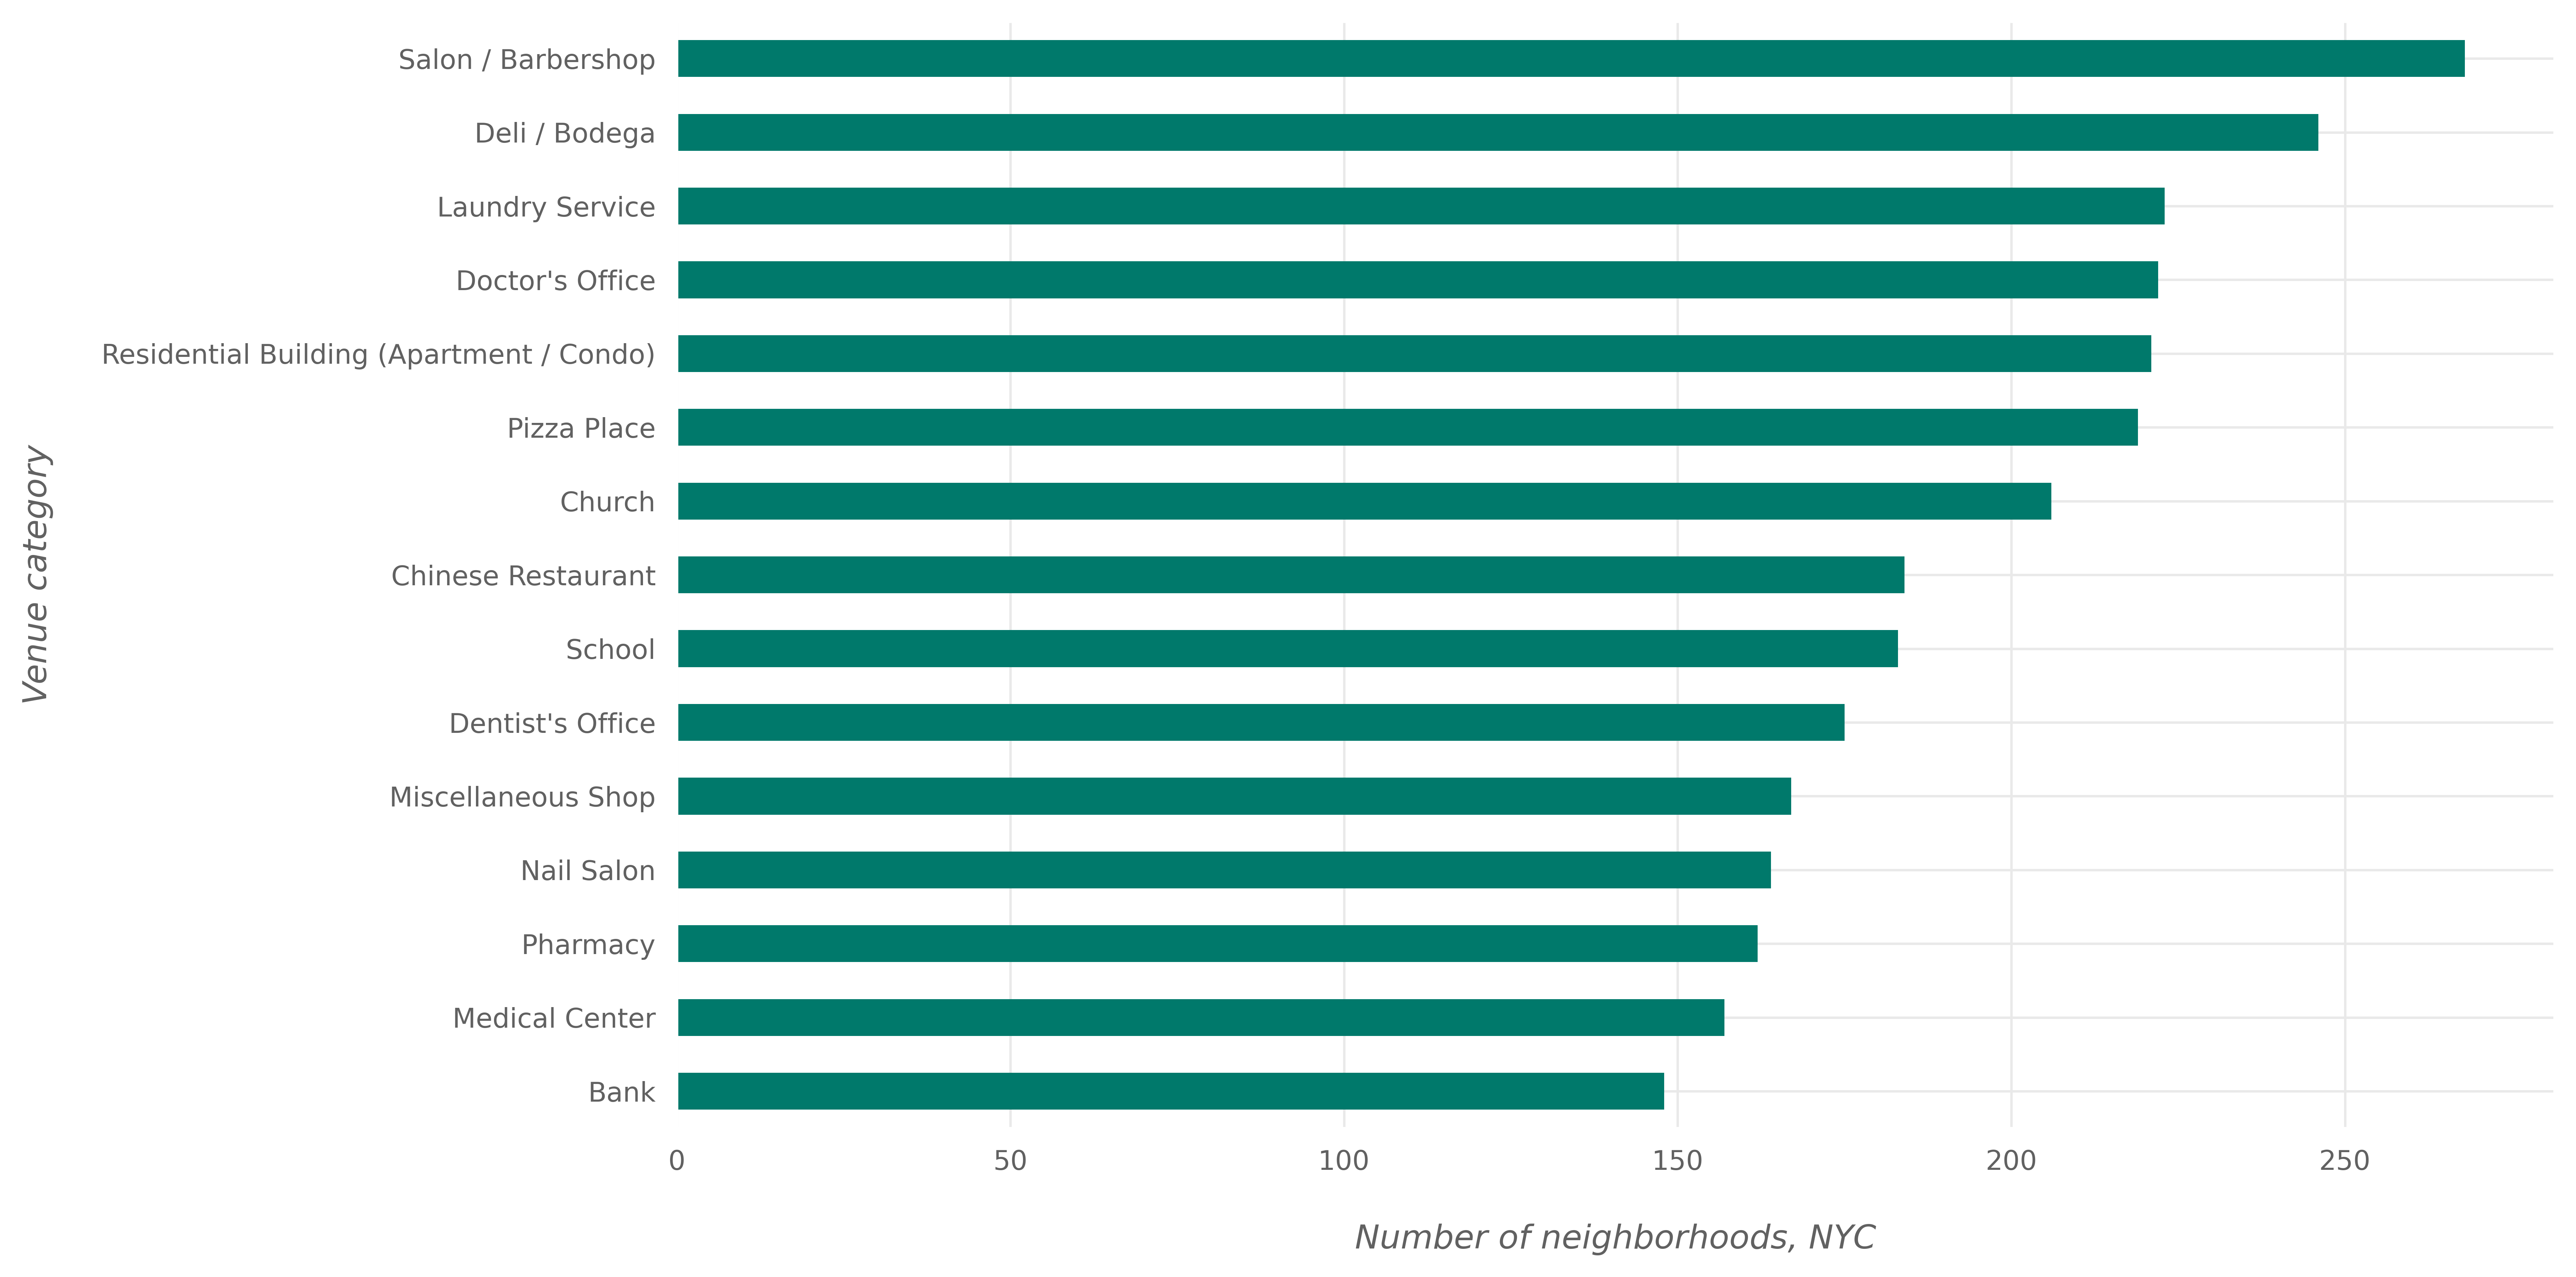

In [73]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_g = nyc_onehot.groupby('Neighborhood_').max().reset_index()
nyc_p = nyc_g.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in NYC".format(nyc_g.shape[0]))
ax = nyc_p.head(15).plot(kind='barh', color=pc[10]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods, NYC', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-nyc.png', dpi=300)

#### Which Venue Categories Exist in More Toronto Neighborhoods?

99 neighborhoods in Toronto


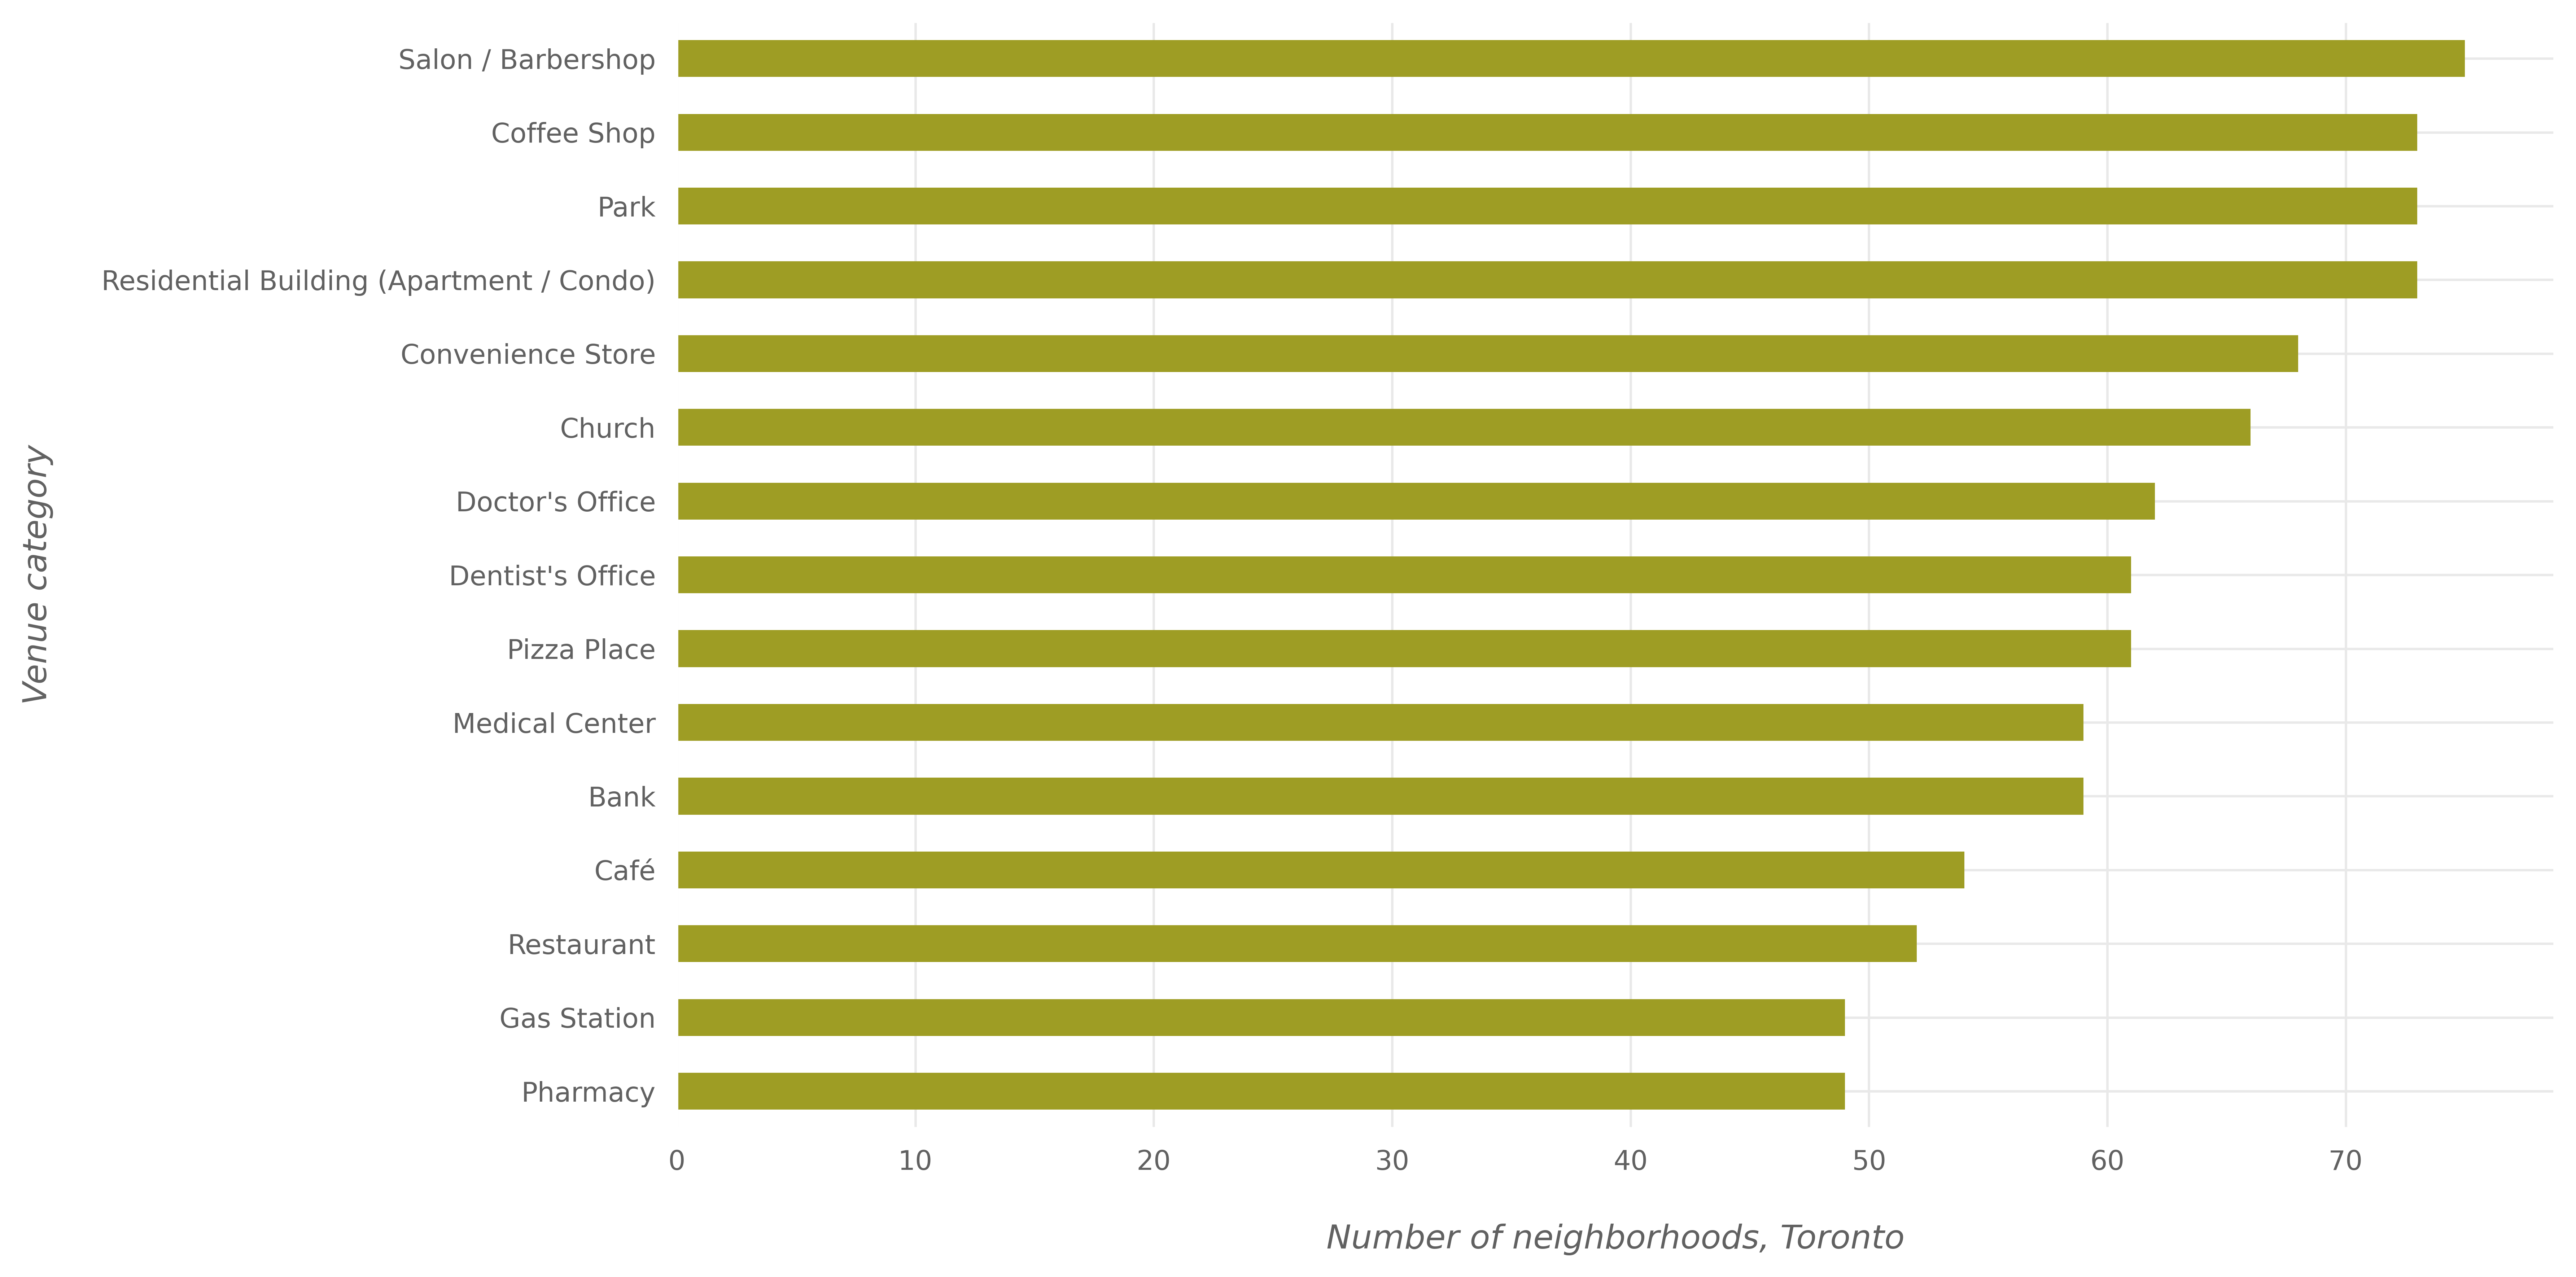

In [74]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_g = tor_onehot.groupby('Neighborhood_').max().reset_index()
tor_p = tor_g.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in Toronto".format(tor_g.shape[0]))
ax = tor_p.head(15).plot(kind='barh', color=pc[7]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods, Toronto', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-tor.png', dpi=300)

#### Rare Categories in NYC

In [75]:
nyc_bot_vc = nyc_venues['Venue Category'].value_counts(normalize=False)
nyc_bot_vc = nyc_bot_vc.tail(15).to_frame('Count')
nyc_bot_vc.index.names = ['Venue Category']
nyc_bot_vc

Count
Venue Category            
Baseball Stadium         1
Paintball Field          1
Well                     1
EV Charging Station      1
Pawn Shop                1
Prayer Room              1
Nature Preserve          1
Paella Restaurant        1
Rehab Center             1
Hockey Field             1
Line / Queue             1
Roller Rink              1
Stadium                  1
Yemeni Restaurant        1
Corporate Cafeteria      1

#### Rare Categories in Toronto

In [76]:
tor_bot_vc = tor_venues['Venue Category'].value_counts(normalize=False)
tor_bot_vc = tor_bot_vc.tail(15).to_frame('Count')
tor_bot_vc.index.names = ['Venue Category']
tor_bot_vc

Count
Venue Category                
Roof Deck                    1
Rental Service               1
Stationery Store             1
Sake Bar                     1
Theme Restaurant             1
Tapas Restaurant             1
National Park                1
Peking Duck Restaurant       1
Big Box Store                1
Swim School                  1
State / Provincial Park      1
Boxing Gym                   1
Hungarian Restaurant         1
Platform                     1
College Theater              1

In [77]:
clmns_nyc_only = set(nyc_grouped.columns).difference(set(tor_grouped.columns))
clmns_tor_only = set(tor_grouped.columns).difference(set(nyc_grouped.columns))

In [78]:
nyc_grouped_ = nyc_grouped.copy()
nyc_grouped_['Neighborhood_'] = nyc_grouped_['Neighborhood_'].apply(lambda x: x + '_NYC')
tor_grouped_ = tor_grouped.copy()
tor_grouped_['Neighborhood_'] = tor_grouped_['Neighborhood_'].apply(lambda x: x + '_Toronto')

for c in clmns_tor_only:
    nyc_grouped_[c] = 0
for c in clmns_nyc_only:
    tor_grouped_[c] = 0
    
all_clmns_sorted = ['Neighborhood_'] + sorted(list(nyc_grouped_.drop('Neighborhood_', axis=1).columns), key=str.lower)
nyc_grouped_ = nyc_grouped_[all_clmns_sorted]
tor_grouped_ = tor_grouped_[all_clmns_sorted]
    
nyc_tor_grouped = pd.concat([nyc_grouped_, tor_grouped_]).reset_index(drop=True)

In [79]:
nyc_tor_grouped.loc[303:308,]

Neighborhood_  Accessories Store  \
303                                        Woodrow_NYC                0.0   
304                                       Woodside_NYC                0.0   
305                                      Yorkville_NYC                0.0   
306                                  Agincourt_Toronto                0.0   
307                     Alderwood, Long Branch_Toronto                0.0   
308  Bathurst Manor, Wilson Heights, Downsview Nort...                0.0   

     Acupuncturist  Adult Boutique  Advertising Agency  Afghan Restaurant  \
303       0.000000             0.0                 0.0                0.0   
304       0.000000             0.0                 0.0                0.0   
305       0.011494             0.0                 0.0                0.0   
306       0.000000             0.0                 0.0                0.0   
307       0.000000             0.0                 0.0                0.0   
308       0.000000             0.0                 0.0                0.0   

     African Restaurant  Airport  Airport Food Court  Airport Gate  \
303                 0.0      0.0                 0.0           0.0   
304                 0.0      0.0                 0.0           0.0   
305                 0.0      0.0                 0.0           0.0   
306                 0.0      0.0                 0.0           0.0   
307                 0.0      0.0                 0.0           0.0   
308                 0.0      0.0                 0.0           0.0   

     Airport Lounge  Airport Service  Airport Terminal  Airport Tram  \
303             0.0              0.0               0.0           0.0   
304             0.0              0.0               0.0           0.0   
305             0.0              0.0               0.0           0.0   
306             0.0              0.0               0.0           0.0   
307             0.0              0.0               0.0           0.0   
308             0.0              0.0               0.0           0.0   

     Alternative Healer  American Restaurant  Animal Shelter  Antique Shop  \
303                 0.0             0.012346             0.0           0.0   
304                 0.0             0.000000             0.0           0.0   
305                 0.0             0.000000             0.0           0.0   
306                 0.0             0.000000             0.0           0.0   
307                 0.0             0.000000             0.0           0.0   
308                 0.0             0.000000             0.0           0.0   

     Aquarium    Arcade  Arepa Restaurant  Argentinian Restaurant  \
303       0.0  0.000000               0.0                     0.0   
304       0.0  0.000000               0.0                     0.0   
305       0.0  0.000000               0.0                     0.0   
306       0.0  0.012658               0.0                     0.0   
307       0.0  0.000000               0.0                     0.0   
308       0.0  0.000000               0.0                     0.0   

     Art Gallery  Art Museum  Art Studio  Arts & Crafts Store  \
303     0.024691         0.0         0.0             0.000000   
304     0.000000         0.0         0.0             0.000000   
305     0.011494         0.0         0.0             0.000000   
306     0.000000         0.0         0.0             0.000000   
307     0.000000         0.0         0.0             0.012346   
308     0.000000         0.0         0.0             0.000000   

     Arts & Entertainment  Asian Restaurant  Assisted Living  Astrologer  \
303                   0.0          0.000000              0.0         0.0   
304                   0.0          0.000000              0.0         0.0   
305                   0.0          0.000000              0.0         0.0   
306                   0.0          0.000000              0.0         0.0   
307                   0.0          0.024691              0.0         0.0   
308                   

In [80]:
nyc_tor_grouped.shape

(405, 628)

In [81]:
# obtaining the most popular categories for each neighborhood
nyc_tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_tor_neighborhoods_categories_sorted['Neighborhood_'] = nyc_tor_grouped['Neighborhood_']

for ind in np.arange(nyc_tor_grouped.shape[0]):
    nyc_tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        nyc_tor_grouped.iloc[ind, :], num_top_cat)

nyc_tor_neighborhoods_categories_sorted.head()

Neighborhood_ 1st Most Common Category 2nd Most Common Category  \
0       Allerton_NYC       Salon / Barbershop          Laundry Service   
1       Annadale_NYC       Salon / Barbershop              Pizza Place   
2  Arden Heights_NYC                     Pool       Salon / Barbershop   
3      Arlington_NYC                   Church          Automotive Shop   
4       Arrochar_NYC            Deli / Bodega          Doctor's Office   

      3rd Most Common Category 4th Most Common Category  \
0                     Pharmacy               Non-Profit   
1                   Nail Salon            Tattoo Parlor   
2  Professional & Other Places            Moving Target   
3  Professional & Other Places           Hardware Store   
4                  Pizza Place          Laundry Service   

                   5th Most Common Category 6th Most Common Category  \
0                           Doctor's Office             Chiropractor   
1                       American Restaurant                      Spa   
2                                      Food       Italian Restaurant   
3  Residential Building (Apartment / Condo)       Salon / Barbershop   
4                                Food Truck             Liquor Store   

  7th Most Common Category  
0              Gas Station  
1                  Butcher  
2         Dentist's Office  
3            Deli / Bodega  
4       Italian Restaurant

#### Most Common Venue Categories in both NYC and Toronto

In [82]:
# fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
# nyc_tor_top_vc = pd.concat([nyc_venues, tor_venues])['Venue Category'].value_counts(normalize=True) * 100
# ax = nyc_tor_top_vc.head(15).plot(kind='barh', color=pc[12]);
# ax.invert_yaxis()
# plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
# fig.savefig('most-common-ven-nyc-tor.png', dpi=300)

#### Rare Categories in both NYC and Toronto

In [83]:
nyc_tor_bot_vc = pd.concat([nyc_venues, tor_venues])['Venue Category'].value_counts(normalize=False)
nyc_tor_bot_vc = nyc_tor_bot_vc.tail(15).to_frame('Count')
nyc_tor_bot_vc.index.names = ['Venue Category']
nyc_tor_bot_vc

Count
Venue Category                     
Airport Food Court                1
Peking Duck Restaurant            1
Stoop Sale                        1
Corporate Amenity                 1
Swiss Restaurant                  1
English Restaurant                1
Cha Chaan Teng                    1
Ethiopian Restaurant              1
Indian Sweet Shop                 1
Kitchen Supply Store              1
Recruiting Agency                 1
Outdoor Event Space               1
Baggage Locker                    1
Sausage Shop                      1
College Engineering Building      1

### Clustering

In [84]:
# the number of clusters
kclusters = 5

nyc_tor_grouped_clustering = nyc_tor_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 2, 1, 2, 2, 3, 4, 1, 4], dtype=int32)

In [85]:
# add clustering labels
nyc_tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# nyc_tor_merged = nyc_tor_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
# tor_merged = tor_merged[~tor_merged['Neighborhood_'].isin(tor_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_tor_merged = nyc_tor_neighborhoods_categories_sorted.set_index('Neighborhood_')

nyc_tor_merged.iloc[300:310] # check the last columns!

Cluster Labels  \
Neighborhood_                                                        
Wingate_NYC                                                      4   
Woodhaven_NYC                                                    4   
Woodlawn_NYC                                                     4   
Woodrow_NYC                                                      2   
Woodside_NYC                                                     4   
Yorkville_NYC                                                    3   
Agincourt_Toronto                                                1   
Alderwood, Long Branch_Toronto                                   2   
Bathurst Manor, Wilson Heights, Downsview North...               0   
Bayview Village_Toronto                                          2   

                                                                    1st Most Common Category  \
Neighborhood_                                                                                  
Wingate_NYC                                                               Salon / Barbershop   
Woodhaven_NYC                                                                  Deli / Bodega   
Woodlawn_NYC                                                                             Bar   
Woodrow_NYC                                                                             Pool   
Woodside_NYC                                                              Salon / Barbershop   
Yorkville_NYC                                       Residential Building (Apartment / Condo)   
Agincourt_Toronto                                                            Automotive Shop   
Alderwood, Long Branch_Toronto                                                       Daycare   
Bathurst Manor, Wilson Heights, Downsview North...                           Doctor's Office   
Bayview Village_Toronto                             Residential Building (Apartment / Condo)   

                                                                    2nd Most Common Category  \
Neighborhood_                                                                                  
Wingate_NYC                                                                           School   
Woodhaven_NYC                                                             Salon / Barbershop   
Woodlawn_NYC                                                              Salon / Barbershop   
Woodrow_NYC                                                                    Grocery Store   
Woodside_NYC                                                                             Bar   
Yorkville_NYC                                                                Laundry Service   
Agincourt_Toronto                                                                     Church   
Alderwood, Long Branch_Toronto                                               Conference Room   
Bathurst Manor, Wilson Heights, Downsview North...  Residential Building (Apartment / Condo)   
Bayview Village_Toronto                                                      Doctor's Office   

                                                   3rd Most Common Category  \
Neighborhood_                                                                 
Wingate_NYC                                                   Deli / Bodega   
Woodhaven_NYC                                               Laundry Service   
Woodlawn_NYC                                                  Deli / Bodega   
Woodrow_NYC                                              Salon / Barbershop   
Woodside_NYC                                                       Platform   
Yorkville_NYC                                                           Spa   
Agincourt_Toronto                                           Doctor's Office   
Alderwood, Long Branch_Toronto                                         Bank   
Bathurst Manor, Wilson Heights, Downsview North...           Medical Center   
Bayview Village_Toronto             

In [86]:
A=nyc_tor_merged['Cluster Labels'].value_counts().to_frame().sort_index()
A.columns=['Total Neighborhoods']
A.index.name='Cluster Label'
A

Total Neighborhoods
Cluster Label                     
0                               40
1                               29
2                              186
3                               52
4                               98

#### Examining clusters

Let's see the neighborhoods in each of the five clusters:


##### Cluster 1

In [87]:
c1 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 0, :]
print(c1.shape)
c1

(40, 8)


Cluster Labels  \
Neighborhood_                                                        
Bloomfield_NYC                                                   0   
Brooklyn Heights_NYC                                             0   
Bulls Head_NYC                                                   0   
Castleton Corners_NYC                                            0   
Concord_NYC                                                      0   
Dyker Heights_NYC                                                0   
Egbertville_NYC                                                  0   
Emerson Hill_NYC                                                 0   
Forest Hills_NYC                                                 0   
Fort Hamilton_NYC                                                0   
Georgetown_NYC                                                   0   
Glendale_NYC                                                     0   
Gramercy_NYC                                                     0   
Greenridge_NYC                                                   0   
Heartland Village_NYC                                            0   
Holliswood_NYC                                                   0   
Kew Gardens_NYC                                                  0   
Lindenwood_NYC                                                   0   
Madison_NYC                                                      0   
Manhattan Terrace_NYC                                            0   
Morris Park_NYC                                                  0   
Murray Hill, Manhattan_NYC                                       0   
New Springville_NYC                                              0   
Norwood_NYC                                                      0   
Oakwood_NYC                                                      0   
Ocean Parkway_NYC                                                0   
Park Hill_NYC                                                    0   
Pelham Gardens_NYC                                               0   
Pelham Parkway_NYC                                               0   
Pomonok_NYC                                                      0   
Rego Park_NYC                                                    0   
Rockaway Park_NYC                                                0   
Schuylerville_NYC                                                0   
South Beach_NYC                                                  0   
Starrett City_NYC                                                0   
Sunnyside, Staten Island_NYC                                     0   
Todt Hill_NYC                                                    0   
Tudor City_NYC                                                   0   
Upper East Side_NYC                                              0   
Bathurst Manor, Wilson Heights, Downsview North...               0   

                                                                    1st Most Common Category  \
Neighborhood_                                                                                  
Bloomfield_NYC                                                               Doctor's Office   
Brooklyn Heights_NYC                                                         Doctor's Office   
Bulls Head_NYC                                                               Doctor's Office   
Castleton Corners_NYC                                                        Doctor's Office   
Concord_NYC                                                                  Doctor's Office   
Dyker Heights_NYC                                                            Doctor's Office   
Egbertville_NYC                                                              Doctor's Office   
Emerson Hill_NYC                                                             Doctor's Office   
Forest Hills_NYC                                                            Dentist's Office   
Fort Hamilton_NYC                                      

Most common categories among all neighborhoods in this cluster:

##### Cluster 2

In [88]:
c2 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 1, :]
print(c2.shape)
c2

(29, 8)


Cluster Labels  \
Neighborhood_                                                        
Arlington_NYC                                                    1   
Auburndale_NYC                                                   1   
Blissville_NYC                                                   1   
College Point_NYC                                                1   
Eastchester_NYC                                                  1   
Hunts Point_NYC                                                  1   
Longwood_NYC                                                     1   
Mariner's Harbor_NYC                                             1   
Mount Eden_NYC                                                   1   
Port Ivory_NYC                                                   1   
Port Richmond_NYC                                                1   
Queens Village_NYC                                               1   
Somerville_NYC                                                   1   
South Jamaica_NYC                                                1   
Springfield Gardens_NYC                                          1   
Steinway_NYC                                                     1   
Travis_NYC                                                       1   
Utopia_NYC                                                       1   
Agincourt_Toronto                                                1   
Dorset Park, Wexford Heights, Scarborough Town ...               1   
Dufferin, Dovercourt Village_Toronto                             1   
Humber Summit_Toronto                                            1   
Malvern, Rouge_Toronto                                           1   
Mimico NW, The Queensway West, South of Bloor, ...               1   
Northwest, West Humber - Clairville_Toronto                      1   
Regent Park, Harbourfront_Toronto                                1   
Rouge Hill, Port Union, Highland Creek_Toronto                   1   
Runnymede, The Junction North_Toronto                            1   
Scarborough Village_Toronto                                      1   

                                                                    1st Most Common Category  \
Neighborhood_                                                                                  
Arlington_NYC                                                                         Church   
Auburndale_NYC                                                               Automotive Shop   
Blissville_NYC                                                                   Gas Station   
College Point_NYC                                                            Automotive Shop   
Eastchester_NYC                                                              Automotive Shop   
Hunts Point_NYC                                                              Automotive Shop   
Longwood_NYC                                                                 Automotive Shop   
Mariner's Harbor_NYC                                                         Automotive Shop   
Mount Eden_NYC                                                               Automotive Shop   
Port Ivory_NYC                                                                 Boat or Ferry   
Port Richmond_NYC                                                            Automotive Shop   
Queens Village_NYC                                                                      Food   
Somerville_NYC                                                               Automotive Shop   
South Jamaica_NYC                                                            Automotive Shop   
Springfield Gardens_NYC                                                      Automotive Shop   
Steinway_NYC                                                                 Automotive Shop   
Travis_NYC                                                                   Automotive Shop   
Utopia_NYC                                               

##### Cluster 3

In [89]:
c3 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 2, :]
print(c3.shape)
c3.tail()

(186, 8)


Cluster Labels  \
Neighborhood_                                         
Wexford, Maryvale_Toronto                         2   
Willowdale, Newtonbrook_Toronto                   2   
Willowdale, Willowdale East_Toronto               2   
Woburn_Toronto                                    2   
Woodbine Heights_Toronto                          2   

                                                     1st Most Common Category  \
Neighborhood_                                                                   
Wexford, Maryvale_Toronto                           Middle Eastern Restaurant   
Willowdale, Newtonbrook_Toronto                                        Church   
Willowdale, Willowdale East_Toronto  Residential Building (Apartment / Condo)   
Woburn_Toronto                                                 Cosmetics Shop   
Woodbine Heights_Toronto                                               Church   

                                    2nd Most Common Category  \
Neighborhood_                                                  
Wexford, Maryvale_Toronto                      Grocery Store   
Willowdale, Newtonbrook_Toronto                         Park   
Willowdale, Willowdale East_Toronto                     Bank   
Woburn_Toronto                                   Coffee Shop   
Woodbine Heights_Toronto                        Intersection   

                                    3rd Most Common Category  \
Neighborhood_                                                  
Wexford, Maryvale_Toronto                     Medical Center   
Willowdale, Newtonbrook_Toronto               Medical Center   
Willowdale, Willowdale East_Toronto       Salon / Barbershop   
Woburn_Toronto                             Convenience Store   
Woodbine Heights_Toronto                                Park   

                                                     4th Most Common Category  \
Neighborhood_                                                                   
Wexford, Maryvale_Toronto                                        Intersection   
Willowdale, Newtonbrook_Toronto                                    Nail Salon   
Willowdale, Willowdale East_Toronto                                      Park   
Woburn_Toronto                       Residential Building (Apartment / Condo)   
Woodbine Heights_Toronto                                   Salon / Barbershop   

                                    5th Most Common Category  \
Neighborhood_                                                  
Wexford, Maryvale_Toronto                        Coffee Shop   
Willowdale, Newtonbrook_Toronto            Convenience Store   
Willowdale, Willowdale East_Toronto          Bubble Tea Shop   
Woburn_Toronto                             Indian Restaurant   
Woodbine Heights_Toronto                                Café   

                                    6th Most Common Category  \
Neighborhood_                                                  
Wexford, Maryvale_Toronto                        Post Office   
Willowdale, Newtonbrook_Toronto              Doctor's Office   
Willowdale, Willowdale East_Toronto              Coffee Shop   
Woburn_Toronto                                      Pharmacy   
Woodbine Heights_Toronto                          Skate Park   

                                    7th Most Common Category  
Neighborhood_                                                 
Wexford, Maryvale_Toronto                 Salon / Barbershop  
Willowdale, Newtonbrook_Toronto                         Bank  
Willowdale, Willowdale East_Toronto   Furniture / Home Store  
Woburn_Toronto                            Salon / Barbershop  
Woodbine Heights_Toronto                        Skating Rink

##### Cluster 4

In [90]:
c4 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 3, :]
print(c4.shape)
c4

(52, 8)


Cluster Labels  \
Neighborhood_                                                        
Astoria_NYC                                                      3   
Bay Terrace, Queens_NYC                                          3   
Bedford Park_NYC                                                 3   
Briarwood_NYC                                                    3   
Bronxdale_NYC                                                    3   
Carnegie Hill_NYC                                                3   
Cobble Hill_NYC                                                  3   
Ditmas Park_NYC                                                  3   
East Williamsburg_NYC                                            3   
Elmhurst_NYC                                                     3   
Flatbush_NYC                                                     3   
Forest Hills Gardens_NYC                                         3   
Fort Greene_NYC                                                  3   
Fresh Meadows_NYC                                                3   
Hamilton Heights_NYC                                             3   
Jackson Heights_NYC                                              3   
Kingsbridge Heights_NYC                                          3   
Lefrak City_NYC                                                  3   
Lower East Side_NYC                                              3   
Melrose_NYC                                                      3   
Midwood_NYC                                                      3   
Morris Heights_NYC                                               3   
Mott Haven_NYC                                                   3   
Prospect Heights_NYC                                             3   
Prospect Lefferts Gardens_NYC                                    3   
Prospect Park South_NYC                                          3   
Ravenswood_NYC                                                   3   
Riverdale_NYC                                                    3   
Rochdale_NYC                                                     3   
Roosevelt Island_NYC                                             3   
South Side_NYC                                                   3   
Spuyten Duyvil_NYC                                               3   
Stuyvesant Town_NYC                                              3   
Turtle Bay_NYC                                                   3   
Upper West Side_NYC                                              3   
Washington Heights_NYC                                           3   
West Village_NYC                                                 3   
Yorkville_NYC                                                    3   
Brockton, Parkdale Village, Exhibition Place_To...               3   
Church and Wellesley_Toronto                                     3   
Davisville North_Toronto                                         3   
Harbourfront East, Union Station, Toronto Islan...               3   
North Park, Maple Leaf Park, Upwood Park_Toronto                 3   
Old Mill South, King's Mill Park, Sunnylea, Hum...               3   
Parkwoods_Toronto                                                3   
Rosedale_Toronto                                                 3   
Summerhill West, Rathnelly, South Hill, Forest ...               3   
The Annex, North Midtown, Yorkville_Toronto                      3   
Victoria Village_Toronto                                         3   
Willowdale, Willowdale West_Toronto                              3   
York Mills West_Toronto                                          3   
York Mills, Silver Hills_Toronto                                 3   

                                                                    1st Most Common Category  \
Neighborhood_                                                                                  
Astoria_NYC                                         Residential Building (Apart

##### Cluster 5

In [91]:
c5 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 4, :]
print(c5.shape)
c5

(98, 8)


Cluster Labels  \
Neighborhood_                                                        
Allerton_NYC                                                     4   
Annadale_NYC                                                     4   
Astoria Heights_NYC                                              4   
Bath Beach_NYC                                                   4   
Bay Ridge_NYC                                                    4   
Bedford Stuyvesant_NYC                                           4   
Beechhurst_NYC                                                   4   
Bellaire_NYC                                                     4   
Bellerose_NYC                                                    4   
Belmont_NYC                                                      4   
Bensonhurst_NYC                                                  4   
Boerum Hill_NYC                                                  4   
Brookville_NYC                                                   4   
Cambria Heights_NYC                                              4   
Canarsie_NYC                                                     4   
Castle Hill_NYC                                                  4   
Central Harlem_NYC                                               4   
City Line_NYC                                                    4   
Claremont Village_NYC                                            4   
Clifton_NYC                                                      4   
Concourse_NYC                                                    4   
Concourse Village_NYC                                            4   
Corona_NYC                                                       4   
Country Club_NYC                                                 4   
Crown Heights_NYC                                                4   
Cypress Hills_NYC                                                4   
Dongan Hills_NYC                                                 4   
Douglaston_NYC                                                   4   
East Elmhurst_NYC                                                4   
East Flatbush_NYC                                                4   
East New York_NYC                                                4   
East Tremont_NYC                                                 4   
Edenwald_NYC                                                     4   
Elm Park_NYC                                                     4   
Eltingville_NYC                                                  4   
Erasmus_NYC                                                      4   
Far Rockaway_NYC                                                 4   
Flatlands_NYC                                                    4   
Floral Park_NYC                                                  4   
Great Kills_NYC                                                  4   
High  Bridge_NYC                                                 4   
Highland Park_NYC                                                4   
Hollis_NYC                                                       4   
Homecrest_NYC                                                    4   
Inwood_NYC                                                       4   
Jamaica Hills_NYC                                                4   
Laurelton_NYC                                                    4   
Little Neck_NYC                                                  4   
Manhattan Valley_NYC                                             4   
Marble Hill_NYC                                                  4   
Maspeth_NYC                                                      4   
Middle Village_NYC                                               4   
Mill Basin_NYC                                                   4   
Morrisania_NYC                                                   4   
Mount Hope_NYC                                                   4   
New Brighton_NYC                                              

In [92]:
clust_cats = []
clusters = [c1, c2, c3, c4, c5]
for i, clus in enumerate(clusters):
    clust_cats.append([])
    for n in clus.index.values:
        if n.endswith('NYC'):
            nn = n[:-4]
            clust_cats[i].extend(list(nyc_venues[nyc_venues['Neighborhood'] == nn]['Venue Category'].values))
        else:
            nn = n[:-8]
            clust_cats[i].extend(list(tor_venues[tor_venues['Neighborhood'] == nn]['Venue Category'].values))
    clust_cats[i] = pd.Series(clust_cats[i]).value_counts(normalize=True) * 100


In [93]:
#clust_cats[0]

In [94]:
tbl_bck = "#363636"
tbl_hdr_bck = "#363636"
tbl_txt = "#BBBBBB"

styles = [
    dict(selector="td", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector="th", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector=".col0", props=[("border-left", "1px solid #bbbbbb")]), 
    
    dict(selector="th.blank:nth-child(2)", props=[("border-left", "1px solid #bbbbbb")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("padding-top", "0"), ("padding-bottom", "8px")]),
    
    dict(selector="th.col_heading", props=[("background", tbl_hdr_bck), 
                                           ("color", "#FFCA91")]),
    
    dict(selector="th.index_name", props=[("background", tbl_hdr_bck), 
                                          ("color", "#8DCDFF")]),
    
    dict(selector="th.blank", props=[("background", tbl_hdr_bck), ("padding", "0")]),
    
    dict(selector="tr:nth-child(2n)", props=[("background", "white")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "1px solid {}".format(tbl_txt))]),
    
    dict(selector="thead tr:nth-child(1) th", props=[("padding-top", "14px !important")]),
    
    dict(selector="tbody tr:last-child td", props=[("padding-bottom", "20px")]),
    
    dict(selector="tbody tr:last-child th", props=[("padding-bottom", "20px")]),
    
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "#8DCDFF")]),
]

In [95]:
for i in range(kclusters):
    c__ = clust_cats[i].to_frame("% of venues")
    c__.index.names = ['Category']
    html = (c__.head(7).style.set_table_styles(styles)
            .set_table_attributes('style="border-collapse: collapse; border: 2px solid #BBBBBB"'))
    display(HTML(disp_fmt.format("Cluster {}".format(i+1))))
    display(html)

In [96]:
n_counts = []
for c in clusters:
    nyc_c = 0
    tor_c = 0
    for n in c.index.values:
        if n.endswith('NYC'):
            nyc_c += 1
        else:
            tor_c += 1
    n_counts.append((nyc_c, tor_c))

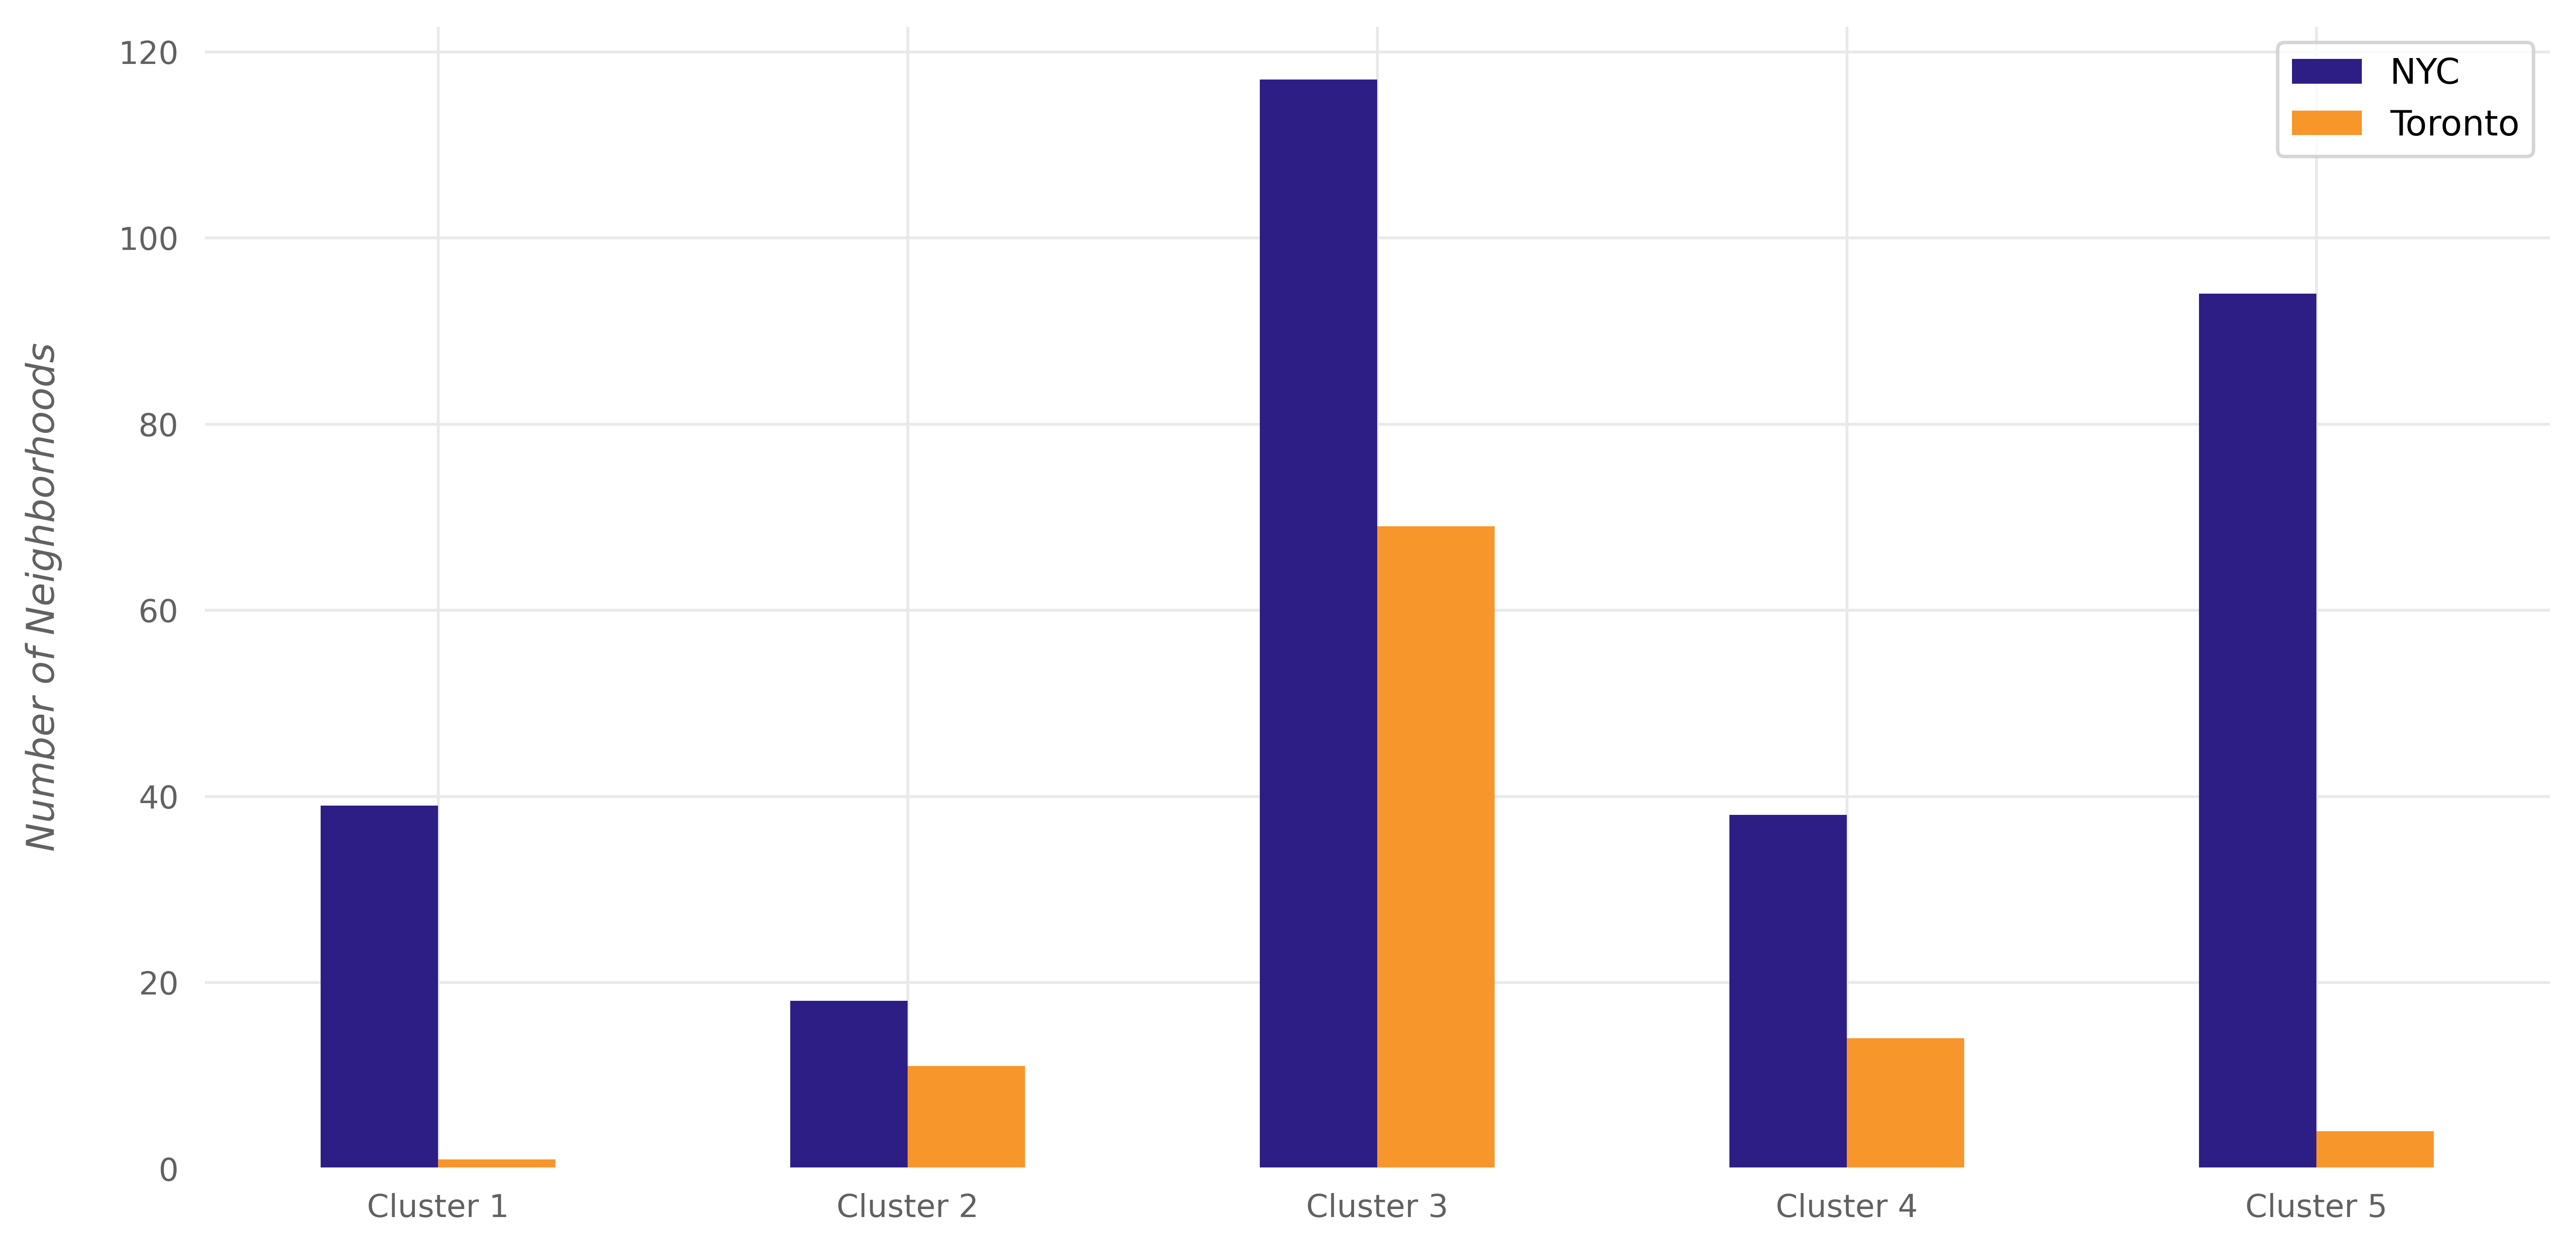

In [97]:
ind = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
city_c_df = pd.DataFrame({
    'NYC': [x[0] for x in n_counts],
    'Toronto': [x[1] for x in n_counts]
}, index = ind)

fig, ax = plt.subplots(figsize=(fig_size), facecolor=fig_fc)
city_c_df.plot(kind='bar', color=['#2d1e86', '#f6962b'], rot=0, ax=ax)
plot_conf(ax, xlbl='', ylbl='Number of Neighborhoods', t='')
#fig.savefig('city-count.png', dpi=300)